# Introduction


**Problem Statement From Kaggle Compettion Description:**

* Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time. How do card issuers know we’ll pay back what we charge? That’s a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.

* Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.
* In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. You're free to explore any technique to create the most powerful model, from creating features to using the data in a more organic way within a model. The target binary variable is calculated by observing 18 months performance window after the latest credit card statement, and if the customer does not pay due amount in 120 days after their latest statement date it is considered a default event.

# Data Preprocessing

In [1]:
#Data Preprocessing Libraries:
import numpy as np 
import pandas as pd  
import re
#Visual Libraties:
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib
import missingno as msno

In [2]:
#Importing SimpleImputer for handling missing value
from sklearn.impute import SimpleImputer
#Importing MissingIndicator for handling missing value
from sklearn.impute import MissingIndicator
#Importing StandardScaler for Standardization
from sklearn.preprocessing import StandardScaler
#Importing OnHotEncoder for encoding categorical variable
from sklearn.preprocessing import OneHotEncoder
#Importing for transformation
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
#Importing PCA for handling dimensonality reduction
from sklearn.decomposition import PCA

#Importing pipeline for chaining model building activities
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as mp
#Importing FeatureUnion for combining transformers
from sklearn.pipeline import FeatureUnion

#Importing samplers for handling data imbalance
from imblearn.combine import SMOTEENN 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 

#Importing train_test_split for train and validation split
from sklearn.model_selection import train_test_split
# importing SelectFromModel to select features from model 
from sklearn.feature_selection import SelectFromModel  

In [3]:
#Importing classifiers to try with
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


#Importing metrics required for model evaluation
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Importing RepeatedKFold for cross validation
from sklearn.model_selection import RepeatedKFold
#Importing for model evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
#Importing RepeatedStratifiedKFold for model evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
#Importing GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.model_selection import ValidationCurve

### About the Data
* The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables
#### Files
* train_data.csv - training data with multiple statement dates per customer_ID
* train_labels.csv - target label for each customer_ID
* test_data.csv - corresponding test data; your objective is to predict the target label for each customer_ID
* sample_submission.csv - a sample submission file in the correct format

 * I will use nrows parameter to load first 100k rows from dataset file for Model building.

In [6]:
#Loading first 100,000 rows of dataframe into variable df_train_sample
df_train_sample = pd.read_csv('/kaggle/input/amex-default-prediction/train_data.csv',nrows=100000)

In [7]:
#Shape of sample training dataframe
print('Shape of dataset is:', df_train_sample.shape)

#Print summary of dataframe (df)
df_train_sample.info()

Shape of dataset is: (100000, 190)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 145.0+ MB


**Observations:**

* So there are 100,000 rows (training examples) with 190 columns (features) in train_data.csv dataset
    * Specifically:  185 features (Columns) as dtype float64, 1 feature (Column) as dtype int64 and 4 features (Columns) as dtype object

In [8]:
#Decribe method for showing numerical statistics for numerical columns of training dataframe
df_train_sample.describe()

P_2          D_39            B_1           B_2           R_1  \
count  99214.000000  1.000000e+05  100000.000000  99963.000000  1.000000e+05   
mean       0.653361  1.549806e-01       0.126169      0.615752  8.096814e-02   
std        0.246656  2.742308e-01       0.215040      0.401972  2.310420e-01   
min       -0.383019  8.701630e-07      -0.295126      0.000003  2.970408e-08   
25%        0.476155  4.565746e-03       0.008944      0.102012  2.886092e-03   
50%        0.692188  9.124156e-03       0.032475      0.814085  5.787872e-03   
75%        0.863579  2.368271e-01       0.129060      1.002235  8.670365e-03   
max        1.009998  5.331360e+00       1.324053      1.010000  2.507711e+00   

                S_3          D_41           B_3          D_42          D_43  \
count  81374.000000  9.996300e+04  9.996300e+04  14614.000000  6.980500e+04   
mean       0.226610  6.344809e-02  1.339622e-01      0.183178  1.569983e-01   
std        0.197674  2.086142e-01  2.347874e-01      0.232319  2.250544e-01   
min       -0.254707  6.837608e-08  4.138581e-07     -0.000219  8.705647e-07   
25%        0.127014  2.916486e-03  5.334665e-03      0.037692  4.223572e-02   
50%        0.163829  5.797278e-03  9.938377e-03      0.121966  8.812157e-02   
75%        0.258561  8.706050e-03  1.612277e-01      0.249639  1.854533e-01   
max        2.918675  5.465303e+00  1.401687e+00      3.252056  9.089694e+00   

       ...        D_136        D_137        D_138         D_139         D_140  \
count  ...  3616.000000  3616.000000  3616.000000  9.818700e+04  9.927400e+04   
mean   ...     0.240878     0.016426     0.174021  1.809009e-01  2.607247e-02   
std    ...     0.208407     0.105929     0.268368  3.807581e-01  1.436151e-01   
min    ...     0.000001     0.000001     0.000008  3.936736e-07  2.982034e-07   
25%    ...     0.008802     0.002637     0.003705  3.022039e-03  2.556094e-03   
50%    ...     0.254010     0.005179     0.007188  6.055295e-03  5.113639e-03   
75%    ...     0.258483     0.007693     0.502094  9.109797e-03  7.676944e-03   
max    ...     1.505785     1.009913     1.507705  1.010000e+00  1.009994e+00   

              D_141         D_142         D_143         D_144         D_145  
count  9.818700e+04  17272.000000  9.818700e+04  9.926700e+04  9.818700e+04  
mean   1.666270e-01      0.396094  1.806810e-01  5.550346e-02  6.278066e-02  
std    3.504973e-01      0.241947  3.805662e-01  1.887721e-01  1.984004e-01  
min    5.642931e-08     -0.014441  1.653580e-08  1.161969e-07  4.609489e-08  
25%    3.030734e-03      0.197756  3.018166e-03  2.755039e-03  3.046179e-03  
50%    6.061747e-03      0.385266  6.072593e-03  5.507457e-03  6.062823e-03  
75%    9.096643e-03      0.568553  9.089420e-03  8.277032e-03  9.095337e-03  
max    1.174753e+00      1.751388  1.010000e+00  1.343284e+00  4.282032e+00  

[8 rows x 186 columns]

In [9]:
#Show first five rows of training df (dataframe)
df_train_sample.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   

   D_136  D_137  D_138     D_139     D_140     D_141  D_142     D_143  \
0    NaN    NaN    NaN  0.002427  0.003706  0.003818    NaN  0.000569   
1    NaN    NaN    NaN  0.003954  0.003167  0.005032    NaN  0.009576   
2    NaN    NaN    NaN  0.003269  0.007329  0.000427    NaN  0.003429   
3    NaN    NaN    NaN  0.006117  0.004516  0.003200    NaN  0.008419   
4    NaN    NaN    NaN  0.003671  0.004946  0.008889    NaN  0.001670   

      D_144     D_145  
0  0.000610  0.002674  
1  0.005492  0.009217  
2  0.006986  0.002603  
3  0.006527  0.009600  
4  0.008126  0.009827  

[5 rows x 190 columns]

In [10]:
#List of training sample columns
df_train_sample.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)

In [11]:
#Loading dataset train_labels.csv
train_labels_df = pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv')

In [12]:
#General properties of labels df
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [13]:
#We can see there are many customers that fall into 2 groups: 1 for Default, 0 for not default
train_labels_df.nunique()

customer_ID    458913
target              2
dtype: int64

In [14]:
#Shape of labels dataframe
print('Shape of dataset is:', train_labels_df.shape)

Shape of dataset is: (458913, 2)


In [15]:
#First 5 rows of training labels df
train_labels_df.head()

customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0

In [16]:
#Loading dataset test_data.csv
df_test_sample = pd.read_csv('/kaggle/input/amex-default-prediction/test_data.csv', nrows=100000, index_col='customer_ID')

In [17]:
print("Shape of test dataframe is:", df_test_sample.shape)
print(df_test_sample.info())

Shape of test dataframe is: (100000, 189)
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to 0246c7eb137ed9b08014d66e29caf1772b0512becef11a1eda0948b8b8908576
Columns: 189 entries, S_2 to D_145
dtypes: float64(185), int64(1), object(3)
memory usage: 145.0+ MB
None


In [18]:
#First 5 rows of test df
df_test_sample.head()

S_2       P_2  \
customer_ID                                                                
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-02-19  0.631315   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-03-25  0.587042   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-04-25  0.609056   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-05-20  0.614911   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-06-15  0.591673   

                                                        D_39       B_1  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.001912  0.010728   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.005275  0.011026   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.003326  0.016390   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.009065  0.021672   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.238794  0.015923   

                                                         B_2       R_1  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.814497  0.007547   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.810848  0.001817   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  1.004620  0.000114   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.816549  0.009722   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.810456  0.002026   

                                                         S_3      D_41  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.168651  0.009971   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.241389  0.000166   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.266976  0.004196   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.188947  0.004123   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.180035  0.000731   

                                                         B_3      D_42  ...  \
customer_ID                                                             ...   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.002347  0.113189  ...   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.009132  0.123035  ...   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.004192  0.125319  ...   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.015325  0.123439  ...   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.011281  0.122212  ...   

                                                    D_136  D_137  D_138  \
customer_ID                                                               
00000469ba478561f23a92a868bd366de6f6527a684c9a2...    NaN    NaN    NaN   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...    NaN    NaN    NaN   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...    NaN    NaN    NaN   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...    NaN    NaN    NaN   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...    NaN    NaN    NaN   

                                                       D_139     D_140  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...       NaN  0.004669   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.000142  0.004940   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.000074  0.002114   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.004743  0.006392   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.008133  0.004329   

                                                       D_141  D_142     D_143  \
customer_ID                                                                     
00000469ba478561f23a92a868bd366de6f6527a684c9a2...       NaN    NaN       NaN   
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.009021    NaN  0.003695   
00000469ba478561f23a92a868bd366de6f6527a684c9a

In [19]:
#Merging of training data, inner takes intersection of the two dataframes based on customer_ID key 
df_train = pd.merge(df_train_sample, train_labels_df, how="inner", on=["customer_ID"])

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 191 entries, customer_ID to target
dtypes: float64(185), int64(2), object(4)
memory usage: 146.5+ MB


**Observations:**

* So there are 100,000 rows (training examples) with 191 columns (features) in the merged training dataframe now containing the labels. Specifically:  185 features (Columns) as dtype float64, 2 features (Column) as dtype int64 and 4 features (Columns) as dtype object

In [23]:
#There are no duplicated rows in the training data
df_train[df_train.duplicated()]

Empty DataFrame
Columns: [customer_ID, S_2, P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_42, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, D_49, B_6, B_7, B_8, D_50, D_51, B_9, R_3, D_52, P_3, B_10, D_53, S_5, B_11, S_6, D_54, R_4, S_7, B_12, S_8, D_55, D_56, B_13, R_5, D_58, S_9, B_14, D_59, D_60, D_61, B_15, S_11, D_62, D_63, D_64, D_65, B_16, B_17, B_18, B_19, D_66, B_20, D_68, S_12, R_6, S_13, B_21, D_69, B_22, D_70, D_71, D_72, S_15, B_23, D_73, P_4, D_74, D_75, D_76, B_24, R_7, D_77, B_25, B_26, D_78, D_79, R_8, R_9, S_16, D_80, R_10, R_11, B_27, D_81, D_82, S_17, R_12, B_28, R_13, D_83, ...]
Index: []

[0 rows x 191 columns]

In [24]:
#Same for test data set
df_test_sample[df_test_sample.duplicated()]

Empty DataFrame
Columns: [S_2, P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_42, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, D_49, B_6, B_7, B_8, D_50, D_51, B_9, R_3, D_52, P_3, B_10, D_53, S_5, B_11, S_6, D_54, R_4, S_7, B_12, S_8, D_55, D_56, B_13, R_5, D_58, S_9, B_14, D_59, D_60, D_61, B_15, S_11, D_62, D_63, D_64, D_65, B_16, B_17, B_18, B_19, D_66, B_20, D_68, S_12, R_6, S_13, B_21, D_69, B_22, D_70, D_71, D_72, S_15, B_23, D_73, P_4, D_74, D_75, D_76, B_24, R_7, D_77, B_25, B_26, D_78, D_79, R_8, R_9, S_16, D_80, R_10, R_11, B_27, D_81, D_82, S_17, R_12, B_28, R_13, D_83, R_14, ...]
Index: []

[0 rows x 189 columns]

In [25]:
#Another way of confirming no duplicated rows train in dataset
any(df_train.isnull().sum())

True

In [26]:
#Same for Test dataset
any(df_test_sample.isnull().sum())

True

In [27]:
#First five rows of combined training df
df_train.head()

customer_ID         S_2       P_2  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-03-09  0.938469   
1  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-04-07  0.936665   
2  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-05-28  0.954180   
3  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-06-13  0.960384   
4  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  2017-07-16  0.947248   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.001733  0.008724  1.006838  0.009228  0.124035  0.008771  0.004709  ...   
1  0.005775  0.004923  1.000653  0.006151  0.126750  0.000798  0.002714  ...   
2  0.091505  0.021655  1.009672  0.006815  0.123977  0.007598  0.009423  ...   
3  0.002455  0.013683  1.002700  0.001373  0.117169  0.000685  0.005531  ...   
4  0.002483  0.015193  1.000727  0.007605  0.117325  0.004653  0.009312  ...   

   D_137  D_138     D_139     D_140     D_141  D_142     D_143     D_144  \
0    NaN    NaN  0.002427  0.003706  0.003818    NaN  0.000569  0.000610   
1    NaN    NaN  0.003954  0.003167  0.005032    NaN  0.009576  0.005492   
2    NaN    NaN  0.003269  0.007329  0.000427    NaN  0.003429  0.006986   
3    NaN    NaN  0.006117  0.004516  0.003200    NaN  0.008419  0.006527   
4    NaN    NaN  0.003671  0.004946  0.008889    NaN  0.001670  0.008126   

      D_145  target  
0  0.002674       0  
1  0.009217       0  
2  0.002603       0  
3  0.009600       0  
4  0.009827       0  

[5 rows x 191 columns]

**Observations:**

* We can definitely see there are multiple columns that have missing values. More analysis to follow.

In [28]:
#NAN's in each column
df_train.isna().sum()

customer_ID        0
S_2                0
P_2              786
D_39               0
B_1                0
               ...  
D_142          82728
D_143           1813
D_144            733
D_145           1813
target             0
Length: 191, dtype: int64

In [29]:
#Total number of NAN's in every column of training df
df_train.isna().sum().sum()

2903555

In [30]:
#Names of columns of training df
df_train.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

In [31]:
#Drop variables with missing values >=70% in the train dataframe
num_cols=0
for col in df_train.columns:
    if (df_train[col].isnull().sum()/len(df_train[col])*100) >=70:
        df_train.drop(axis=1,labels=col,inplace=True)
        print("Dropping column", col)
        num_cols+=1
print("Total number of columns dropped in train dataframe", num_cols)

Dropping column D_42
Dropping column D_49
Dropping column D_53
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column D_82
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in train dataframe 25


In [32]:
#Drop variables with missing values >=70% in the test dataframe
num_cols=0
for col in df_test_sample.columns:
    if (df_test_sample[col].isnull().sum()/len(df_test_sample[col])*100) >=70:
        df_test_sample.drop(axis=1,labels=col,inplace=True)
        print("Dropping column", col)
        num_cols+=1
print("Total number of columns dropped in test dataframe", num_cols)

Dropping column D_42
Dropping column D_49
Dropping column D_53
Dropping column D_66
Dropping column D_73
Dropping column D_76
Dropping column R_9
Dropping column D_82
Dropping column B_29
Dropping column D_87
Dropping column D_88
Dropping column D_106
Dropping column R_26
Dropping column D_108
Dropping column D_110
Dropping column D_111
Dropping column B_39
Dropping column B_42
Dropping column D_132
Dropping column D_134
Dropping column D_135
Dropping column D_136
Dropping column D_137
Dropping column D_138
Dropping column D_142
Total number of columns dropped in test dataframe 25


In [33]:
#New training df characteristics
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 166 entries, customer_ID to target
dtypes: float64(160), int64(2), object(4)
memory usage: 127.4+ MB


In [34]:
#New test df sample characteristics
df_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to 0246c7eb137ed9b08014d66e29caf1772b0512becef11a1eda0948b8b8908576
Columns: 164 entries, S_2 to D_145
dtypes: float64(160), int64(1), object(3)
memory usage: 125.9+ MB


In [35]:
#Convert dtype for B categorical variable to object for train df
df_train = df_train.astype({"B_30": 'str', "B_38": 'str'})
#Convert dtype for B categorical variable to object for test df
df_test_sample = df_test_sample.astype({"B_30": 'str', "B_38": 'str'})
#Convert dtype for D categorical variable to object for train df
df_train = df_train.astype({"D_114": 'str', "D_116": 'str', "D_117": 'str', "D_120": 'str', "D_126": 'str', "D_68": 'str'})
#Convert dtype for D categorical variable to object for test df
df_test_sample = df_test_sample.astype({"D_114": 'str', "D_116": 'str', "D_117": 'str', "D_120": 'str', "D_126": 'str', "D_68": 'str'})

## Deeper Look at Each Variable In Training Data

In [37]:
#Extract columns names for easy access: 
D_columns = [col for col in df_train.columns if 'D_' in col]
print ("Total number of columns starting with D is", len(D_columns))
print("---------------------------------------")
#Segregate D Columns for easier access using regex
#Regex to capture column name with D_$$ (D_ and 2 digit number suffix)
d_col1 = "D_[0-9][0-9]$$"
#Regex to capture column name with D_$$$ (D_ and 3 digit number suffix)
d_col2 = "D_[0-9][0-9][0-9]$$$"
#Get first set of column name which matches regex for d_col1
D_columns1 = [col for col in df_train.columns if re.match(d_col1,col)]
print ("First set of columns starting with D is", len(D_columns1))
print(D_columns1)
#Get second set of column name which matches regex for d_col2
D_columns2 = [col for col in df_train.columns if re.match(d_col2,col)]
print ("Second set of columns starting with D is", len(D_columns2))
print(D_columns2)
print ("Total Number of columns starting with D is", len(D_columns2)+len(D_columns1))
print("---------------------------------------")
S_columns = [col for col in df_train.columns if 'S_' in col]
print ("Total number of columns starting with S is", len(S_columns))
print(S_columns)
print("---------------------------------------")
P_columns = [col for col in df_train.columns if 'P_' in col]
print ("Total number of columns starting with P is", len(P_columns))
print(P_columns)
print("---------------------------------------")
B_columns = [col for col in df_train.columns if 'B_' in col]
print ("Total number of columns starting with B is", len(B_columns))
print(B_columns)
print("---------------------------------------")
R_columns = [col for col in df_train.columns if 'R_' in col]
print ("Toal number of columns starting with R is", len(R_columns))
print(R_columns)
print("---------------------------------------")
total_columns = len(D_columns1)+len(D_columns2)+len(S_columns)+len(P_columns)+len(B_columns)+len(R_columns)
print("Total number of D, S, P, B, R variables(columns) per customer_ID  is",total_columns)
print("---------------------------------------")

Total number of columns starting with D is 76
---------------------------------------
First set of columns starting with D is 43
['D_39', 'D_41', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_52', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_74', 'D_75', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_83', 'D_84', 'D_86', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']
Second set of columns starting with D is 33
['D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'D_109', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145']
Total Number of columns starting with D is 76
---------------------------------------
Total number of columns starting with S is 22
['S_2', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S

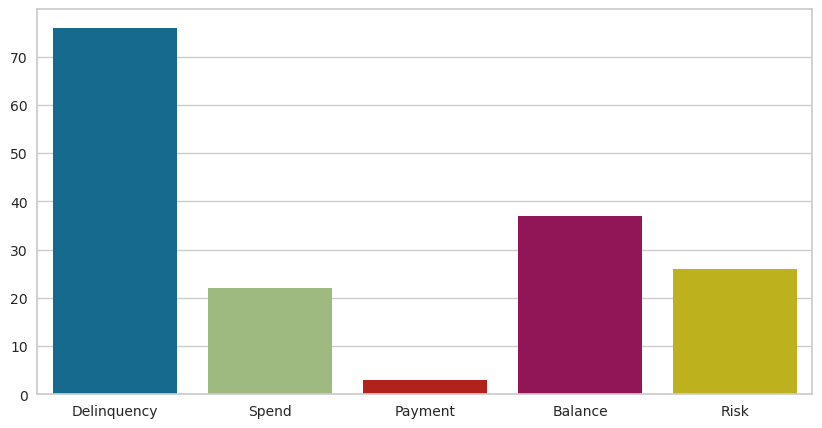

In [38]:
#Barplot counting each type of feature
Dict = {'Delinquency': len(D_columns), 'Spend': len(S_columns), 'Payment': len(P_columns), 'Balance': len(B_columns), 'Risk': len(R_columns),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));

**Observation:**
* Deliquency variables have the most features

In [39]:
#Display data for columns starting with D. We can see there are a few NAN's
df_train.filter(like='D_', axis=1)

D_39      D_41      D_43      D_44      D_45      D_46      D_47  \
0      0.001733  0.008771       NaN  0.000630  0.708906  0.358587  0.525351   
1      0.005775  0.000798       NaN  0.002526  0.712795  0.353630  0.521311   
2      0.091505  0.007598       NaN  0.007605  0.720884  0.334650  0.524568   
3      0.002455  0.000685       NaN  0.006406  0.723997  0.323271  0.530929   
4      0.002483  0.004653       NaN  0.007731  0.720619  0.231009  0.529305   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.124405  0.000963  0.120353  0.252120  0.053603  0.559376  0.418322   
99996  0.038383  0.000720  0.058647  0.508251  0.058924  0.644493  0.422213   
99997  0.036849  0.003972  0.059105  0.626476  0.065946  0.743611  0.420412   
99998  0.000546  0.008652  0.276448  0.125936  0.089861  0.437422  0.169624   
99999  0.008513  0.002812  0.225040  0.128269  0.095753  0.543441  0.173296   

           D_48      D_50      D_51  ...     D_129     D_130     D_131  \
0      0.255736  0.148698  1.335856  ...  1.000080  0.002052  0.005972   
1      0.223329  0.149723  1.339794  ...  1.008344  0.001034  0.004838   
2      0.189424  0.151955  1.337179  ...  1.006878  0.005681  0.005497   
3      0.135586  0.151219  1.339909  ...  1.007573  0.007108  0.008261   
4           NaN  0.154026  1.341735  ...  1.008132  0.009680  0.004848   
...         ...       ...       ...  ...       ...       ...       ...   
99995  0.622826       NaN  0.002646  ...  0.007861  0.004188  0.008937   
99996  0.685554       NaN  0.008311  ...  0.007739  0.007115  0.008121   
99997  0.755215       NaN  0.001198  ...  0.001361  0.006973  0.003287   
99998  0.376802       NaN  0.008101  ...  0.002981  0.000770  0.002454   
99999  0.498679       NaN  0.009768  ...  0.006946  0.002015  0.000721   

          D_133     D_139     D_140     D_141     D_143     D_144     D_145  
0      0.004345  0.002427  0.003706  0.003818  0.000569  0.000610  0.002674  
1      0.007495  0.003954  0.003167  0.005032  0.009576  0.005492  0.009217  
2      0.009227  0.003269  0.007329  0.000427  0.003429  0.006986  0.002603  
3      0.007206  0.006117  0.004516  0.003200  0.008419  0.006527  0.009600  
4      0.006312  0.003671  0.004946  0.008889  0.001670  0.008126  0.009827  
...         ...       ...       ...       ...       ...       ...       ...  
99995  0.005341  0.004281  0.003969  0.003936  0.006478  0.003046  0.004138  
99996  0.007213  0.004239  0.008563  0.003117  0.006679  0.007450  0.002982  
99997  0.001053  0.009920  0.005579  0.008481  0.001516  0.005997  0.004767  
99998  0.003254  1.006665  0.003085  0.914985  1.001686  0.579711  0.454960  
99999  0.005067  1.006981  0.003211  0.914737  1.001302  0.669118  0.460121  

[100000 rows x 76 columns]

In [40]:
#Same thing for S variables
df_train.filter(like='S_', axis=1)

S_2       S_3       S_5       S_6       S_7       S_8       S_9  \
0      2017-03-09  0.124035  0.023381  0.008322  0.161345  0.922998  0.065728   
1      2017-04-07  0.126750  0.030599  0.002482  0.140951  0.919414  0.093935   
2      2017-05-28  0.123977  0.048367  0.000530  0.112229  1.001977  0.084757   
3      2017-06-13  0.117169  0.030063  0.000783  0.102838  0.704016  0.048382   
4      2017-07-16  0.117325  0.054221  0.006698  0.094311  0.917133  0.039259   
...           ...       ...       ...       ...       ...       ...       ...   
99995  2018-01-02  0.162860  0.003671  1.003519  0.106078  0.664955       NaN   
99996  2018-02-27  0.160133  0.004589  0.009121  0.102220  0.004212       NaN   
99997  2018-03-08  0.166246  0.005730  0.009046  0.102649  0.007804       NaN   
99998  2017-03-29       NaN  0.001485  1.009798       NaN  0.009353       NaN   
99999  2017-04-28       NaN  0.003287  1.003678       NaN  0.004962       NaN   

           S_11      S_12      S_13  ...      S_17      S_18      S_19  \
0      0.401619  0.272008  0.515222  ...  0.008033  0.005720  0.002537   
1      0.406326  0.188970  0.509048  ...  0.000760  0.007584  0.008427   
2      0.406768  0.495308  0.679257  ...  0.004056  0.005901  0.007327   
3      0.405175  0.508670  0.515282  ...  0.006969  0.002520  0.007053   
4      0.487460  0.216507  0.507712  ...  0.001770  0.000155  0.007728   
...         ...       ...       ...  ...       ...       ...       ...   
99995  0.483669  0.185748  0.426306  ...  0.004245  0.006308  0.002001   
99996  0.284908  0.184445  0.000856  ...  0.007683  0.003194  0.007621   
99997  0.286198  0.185529  0.001797  ...  0.005782  0.009422  0.008363   
99998  0.281242  0.188374  0.001410  ...  0.007239  0.007558  0.007195   
99999  0.286356  0.186672  0.002139  ...  0.005762  0.002039  0.000545   

           S_20      S_22      S_23      S_24      S_25      S_26      S_27  
0      0.009705  0.894090  0.135561  0.911191  0.974539  0.001243  0.676922  
1      0.009924  0.902135  0.136333  0.919876  0.975624  0.004561  0.822281  
2      0.008446  0.939654  0.134938  0.958699  0.974067  0.011736  0.853498  
3      0.006614  0.913205  0.140058  0.926341  0.975499  0.007571  0.844667  
4      0.005511  0.921026  0.131620  0.933479  0.978027  0.018200  0.811199  
...         ...       ...       ...       ...       ...       ...       ...  
99995  0.002984  0.927312  0.136109  0.934297  0.973335  0.008895  0.000456  
99996  0.002146  0.927598  0.139274  0.934902  0.975162  0.003994  0.008081  
99997  0.002412  0.923396  0.137267  0.932529  0.972051  0.005734  0.003518  
99998  0.006557  0.296741  0.135450  0.080604  0.969829  0.001976       NaN  
99999  0.009537  0.297361  0.134459  0.081549  0.971570  0.001137       NaN  

[100000 rows x 22 columns]

In [41]:
#Same thing for P variables
df_train.filter(like='P_', axis=1)

P_2       P_3       P_4
0      0.938469  0.736463  0.007554
1      0.936665  0.720886  0.004832
2      0.954180  0.738044  0.006561
3      0.960384  0.741813  0.009559
4      0.947248  0.691986  0.008156
...         ...       ...       ...
99995  0.458911  0.800521  0.002580
99996  0.363298  0.455359  0.000531
99997  0.356621  0.525428  0.000818
99998  0.714477  0.914447  0.002444
99999  0.614861  0.489254  0.007256

[100000 rows x 3 columns]

In [42]:
#Same thing for B variables
df_train.filter(like='B_', axis=1)

B_1       B_2       B_3       B_4       B_5       B_6       B_7  \
0      0.008724  1.006838  0.004709  0.080986  0.170600  0.063902  0.059416   
1      0.004923  1.000653  0.002714  0.069419  0.113239  0.065261  0.057744   
2      0.021655  1.009672  0.009423  0.068839  0.060492  0.066982  0.056647   
3      0.013683  1.002700  0.005531  0.055630  0.166782  0.083720  0.049253   
4      0.015193  1.000727  0.009312  0.038862  0.143630  0.075900  0.048918   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.597829  0.023698  0.627714  0.360951  0.011009  0.011536  0.521920   
99996  0.675999  0.023201  0.822903  0.406486  0.013573  0.013677  0.524812   
99997  0.645728  0.020585  0.871214  0.398912  0.007250  0.007949  0.528713   
99998  0.008019  0.817670  0.008341  0.356096  0.001831  0.043211  0.356317   
99999  0.008796  0.813174  0.009391  0.112514  0.004324  0.041399  0.168414   

            B_8       B_9      B_10  ...      B_28  B_30  B_31      B_32  \
0      0.006466  0.008207  0.096219  ...  0.084683   0.0     1  0.006626   
1      0.001614  0.008373  0.099804  ...  0.081843   0.0     1  0.001854   
2      0.005126  0.009355  0.134073  ...  0.081954   0.0     1  0.008686   
3      0.001418  0.006782  0.134437  ...  0.060634   0.0     1  0.002478   
4      0.001199  0.000519  0.121518  ...  0.062492   0.0     1  0.002199   
...         ...       ...       ...  ...       ...   ...   ...       ...   
99995  1.005980  0.625836  0.018762  ...  0.402110   1.0     1  1.006581   
99996  1.004071  0.620252  0.008919  ...  0.433952   1.0     1  0.001145   
99997  1.002330  0.615262  0.018506  ...  0.427022   1.0     1  0.002013   
99998  1.003488  0.003620  0.016049  ...  0.130414   0.0     1  0.002254   
99999  1.007734  0.001243  0.019759  ...  0.053533   0.0     1  0.002670   

           B_33      B_36      B_37  B_38      B_40      B_41  
0      1.001101  0.009968  0.004572   2.0  0.210060  0.006805  
1      1.006779  0.003921  0.004654   2.0  0.184093  0.004407  
2      1.001014  0.001264  0.019176   2.0  0.154837  0.003221  
3      1.002775  0.002729  0.011720   2.0  0.153939  0.007703  
4      1.006536  0.009998  0.017598   2.0  0.120717  0.009823  
...         ...       ...       ...   ...       ...       ...  
99995  0.009367  0.007672  0.594097   7.0  0.279545  0.007559  
99996  0.004368  0.003274  0.674203   6.0  0.306964  0.006966  
99997  0.000287  0.006013  0.650203   6.0  0.310772  0.001757  
99998  1.004854  0.004141  0.000765   1.0  0.250556  0.006677  
99999  1.002161  0.009148  0.006395   1.0  0.053702  0.002879  

[100000 rows x 37 columns]

In [43]:
#Same thing for R variables
df_train.filter(like='R_', axis=1)

R_1       R_2       R_3       R_4       R_5       R_6       R_7  \
0      0.009228  0.006204  0.001423  0.008298  0.001882  0.008363  0.007562   
1      0.006151  0.006206  0.001984  0.005136  0.001610  0.004030  0.005304   
2      0.006815  0.003259  0.007426  0.006961  0.006328  0.006838  0.001422   
3      0.001373  0.009918  0.003515  0.008706  0.004980  0.008183  0.006363   
4      0.007605  0.006667  0.001362  0.003846  0.001653  0.008605  0.004831   
...         ...       ...       ...       ...       ...       ...       ...   
99995  0.004703  0.002830  0.001867  0.005602  0.001917  0.006611  0.003722   
99996  0.006627  0.000854  0.007511  0.000665  0.000468  0.008671  0.004958   
99997  0.004587  0.003531  0.009798  0.006756  0.007217  0.008475  0.001212   
99998  0.006265  0.009700  0.201372  0.000607  0.003720  0.003783  0.007968   
99999  0.008680  0.006540  0.204884  0.009454  0.009074  0.005819  0.002360   

            R_8      R_10      R_11  ...      R_18      R_19      R_20  \
0      0.001434  0.007121  0.002456  ...  0.008907  0.005177  0.007782   
1      0.000509  0.005966  0.000395  ...  0.005907  0.008979  0.005987   
2      0.008295  0.005447  0.007345  ...  0.008882  0.002016  0.007291   
3      0.005153  0.001888  0.004961  ...  0.008348  0.003909  0.009977   
4      0.007338  0.006111  0.002246  ...  0.002678  0.003432  0.004105   
...         ...       ...       ...  ...       ...       ...       ...   
99995  0.000094  0.001921  0.008687  ...  0.006152  0.008637  0.006685   
99996  0.008745  0.003169  0.006492  ...  0.006258  0.008926  0.002764   
99997  0.008836  0.004486  0.008521  ...  0.003657  0.007011  0.005289   
99998  0.008976  0.006302  0.504921  ...  0.000452  0.001292  0.004610   
99999  0.002806  0.009540  0.000639  ...  0.004529  0.001676  0.008410   

           R_21      R_22      R_23      R_24      R_25      R_27      R_28  
0      0.002450  0.007479  0.006893  0.003950  0.003647  1.008949  0.001535  
1      0.002247  0.006827  0.002837  0.008351  0.008850  1.003205  0.004931  
2      0.007794  0.009820  0.005080  0.002471  0.009769  1.000754  0.009123  
3      0.007686  0.000458  0.007320  0.008507  0.004858  1.005338  0.002409  
4      0.009656  0.003341  0.000264  0.007190  0.002983  1.003175  0.004462  
...         ...       ...       ...       ...       ...       ...       ...  
99995  0.000638  0.001164  0.003237  0.008689  0.005586  1.007739  0.000816  
99996  0.000135  0.001748  0.005861  0.008008  0.000410  1.008753  0.001219  
99997  0.008655  0.002177  0.007047  0.003928  0.002760  1.005128  0.009029  
99998  0.001527  0.000086  0.002535  0.003271  0.005793  1.008218  0.007641  
99999  0.008348  0.005072  0.007160  0.002584  0.008217  1.000504  0.005089  

[100000 rows x 26 columns]

# Exploratory Data Analysis

## D_* = Deliquency Variables

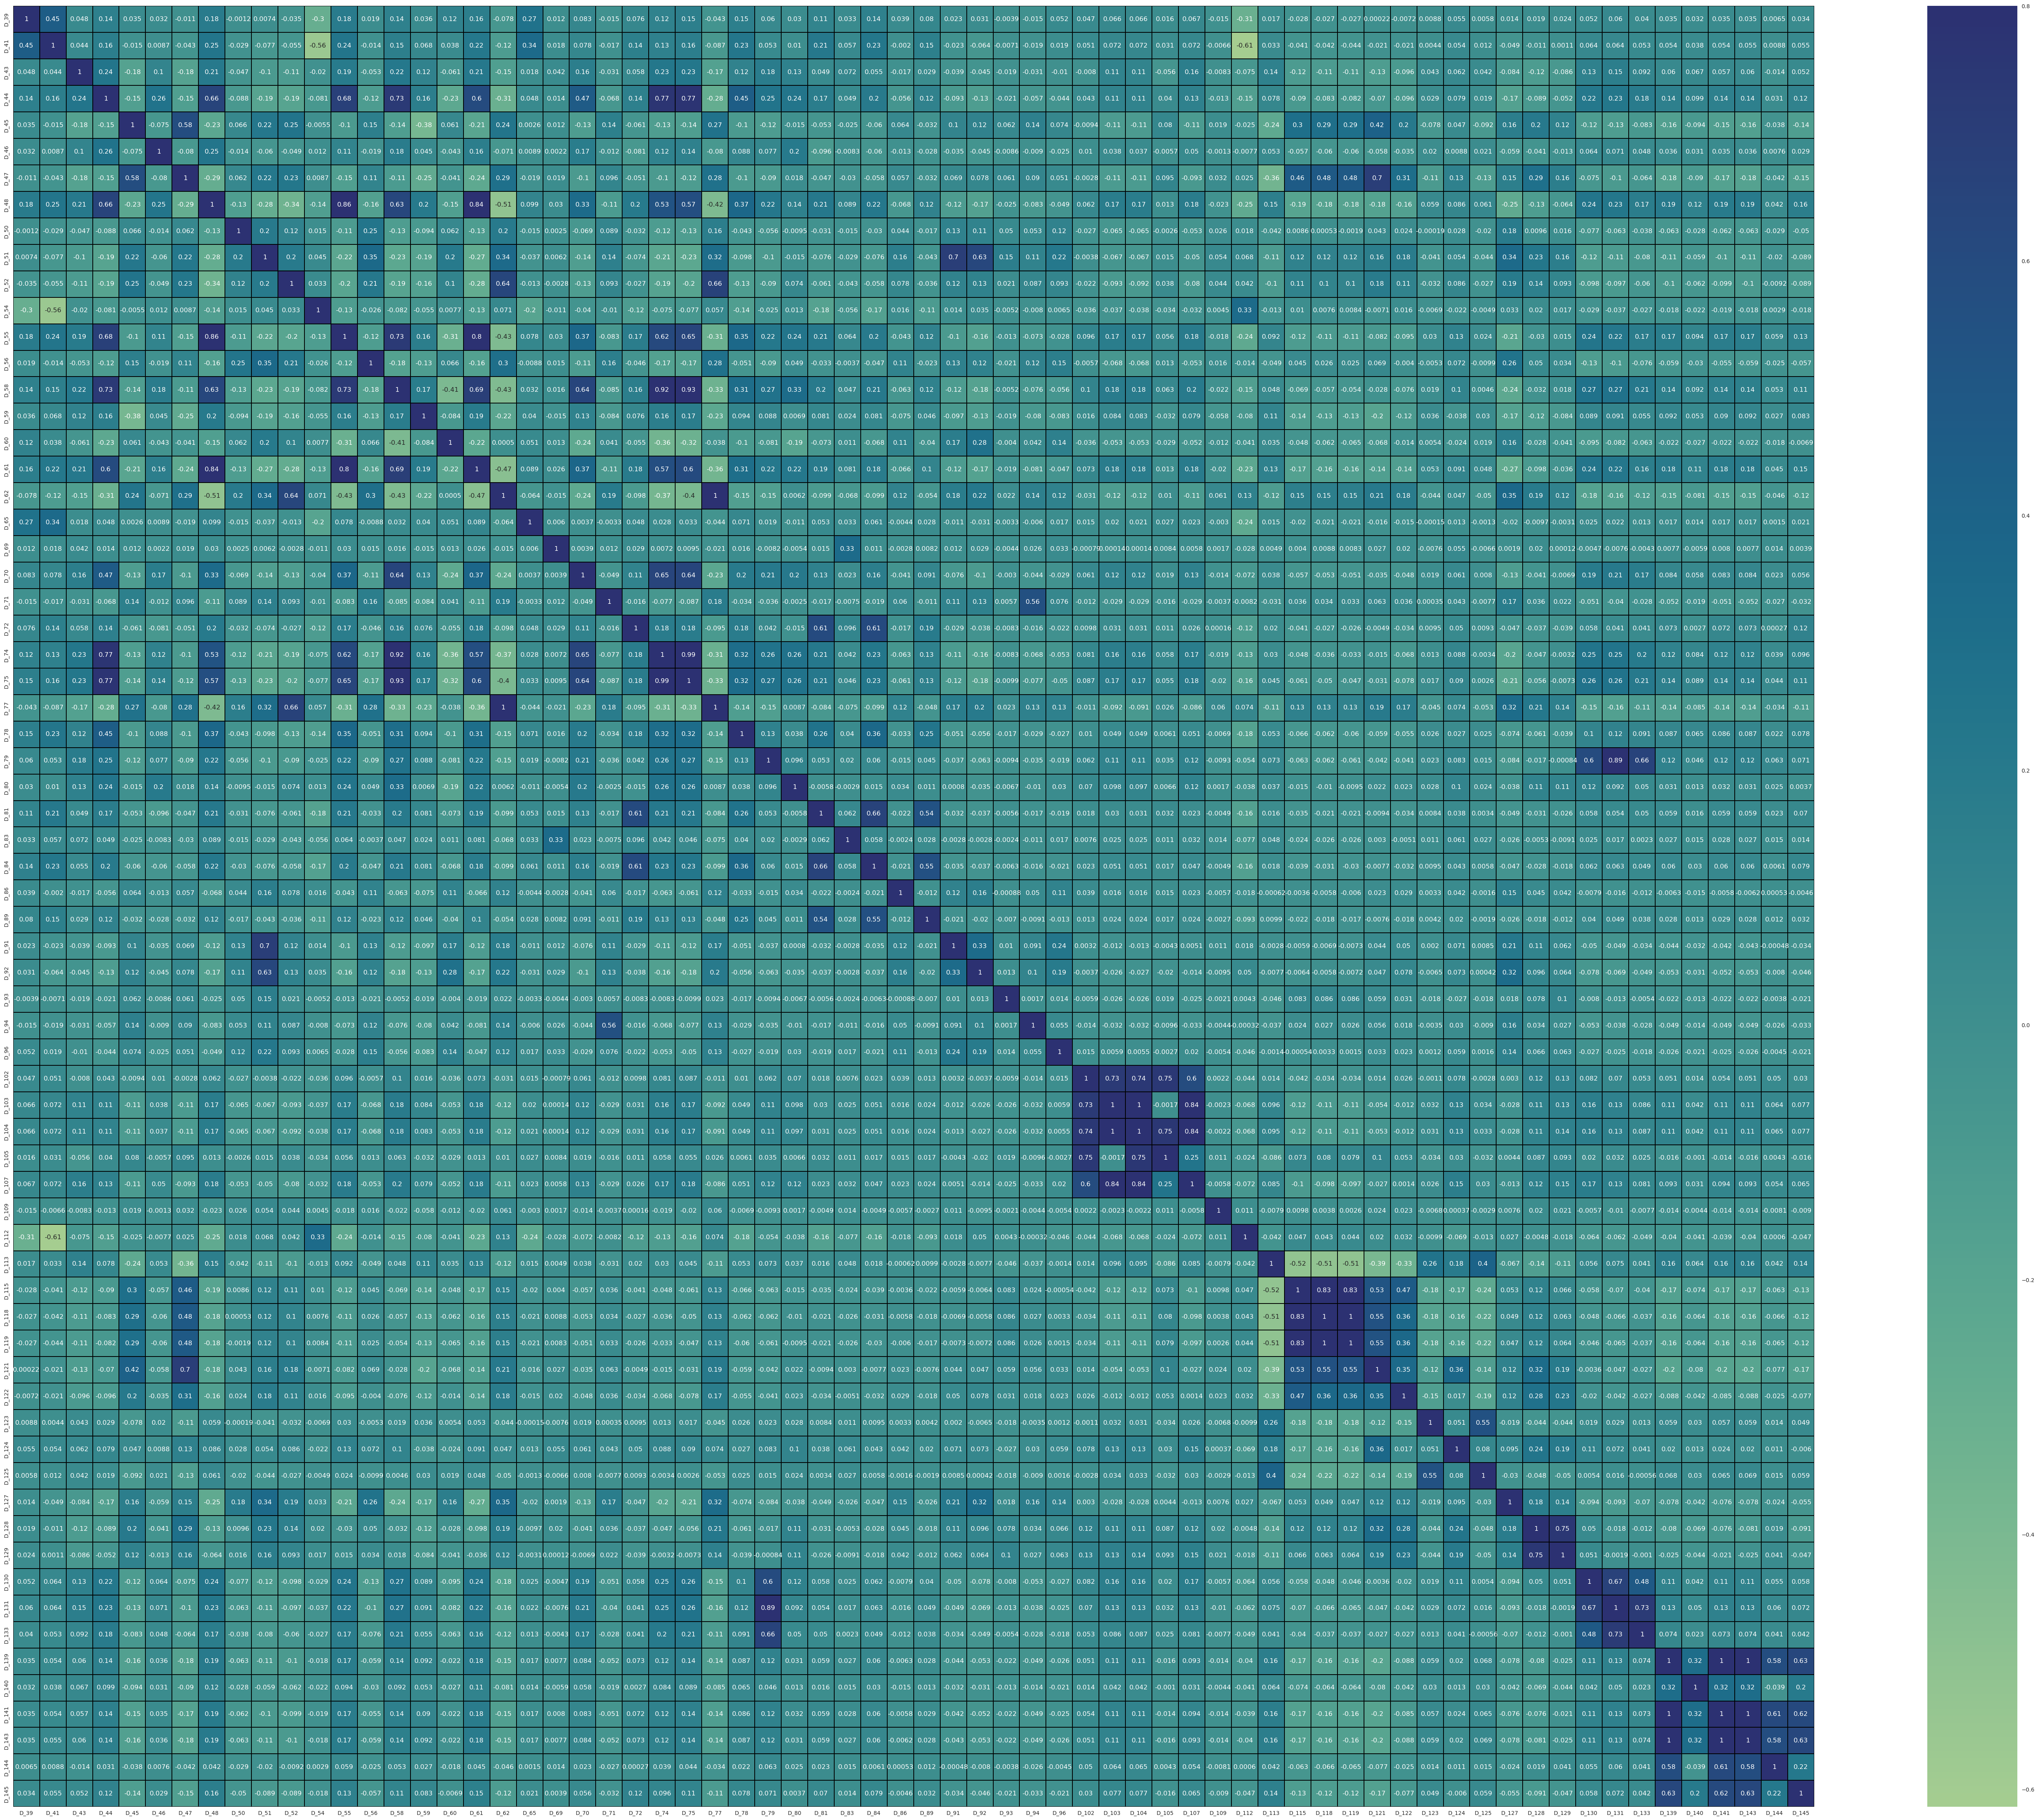

In [44]:
#Plot correlation between D variables
corr = df_train[D_columns].corr(method='pearson')
plt.figure(figsize=(75,60))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='crest',linecolor ='black')
plt.show()

**Highest Correlations among D_ variables:**

* D_58 has correlation of 0.92 with D_74 and 0.93 with D_75
* D_62 has correlation of 1.0 with D_77
* D_74 has correlation of 0.99 with D_75
* D_139 has correlation of 1.0 with D_143 and D_141
* D_141 has correlation of 1.0 with D_143
* D_48 has correlation of 0.84 with D_55 and 0.86 with D_61
* D_79 has correlation of 0.89 with D_131

In [45]:
#List of D features
d_columns= ['D_39', 'D_41', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_52', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62','D_65','D_69', 'D_70', 'D_71', 'D_72', 'D_74', 'D_75', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_83', 'D_84', 'D_86', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96','D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'D_109', 'D_112', 'D_113','D_115', 'D_116', 'D_117','D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125','D_126','D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145']
len(d_columns)

72

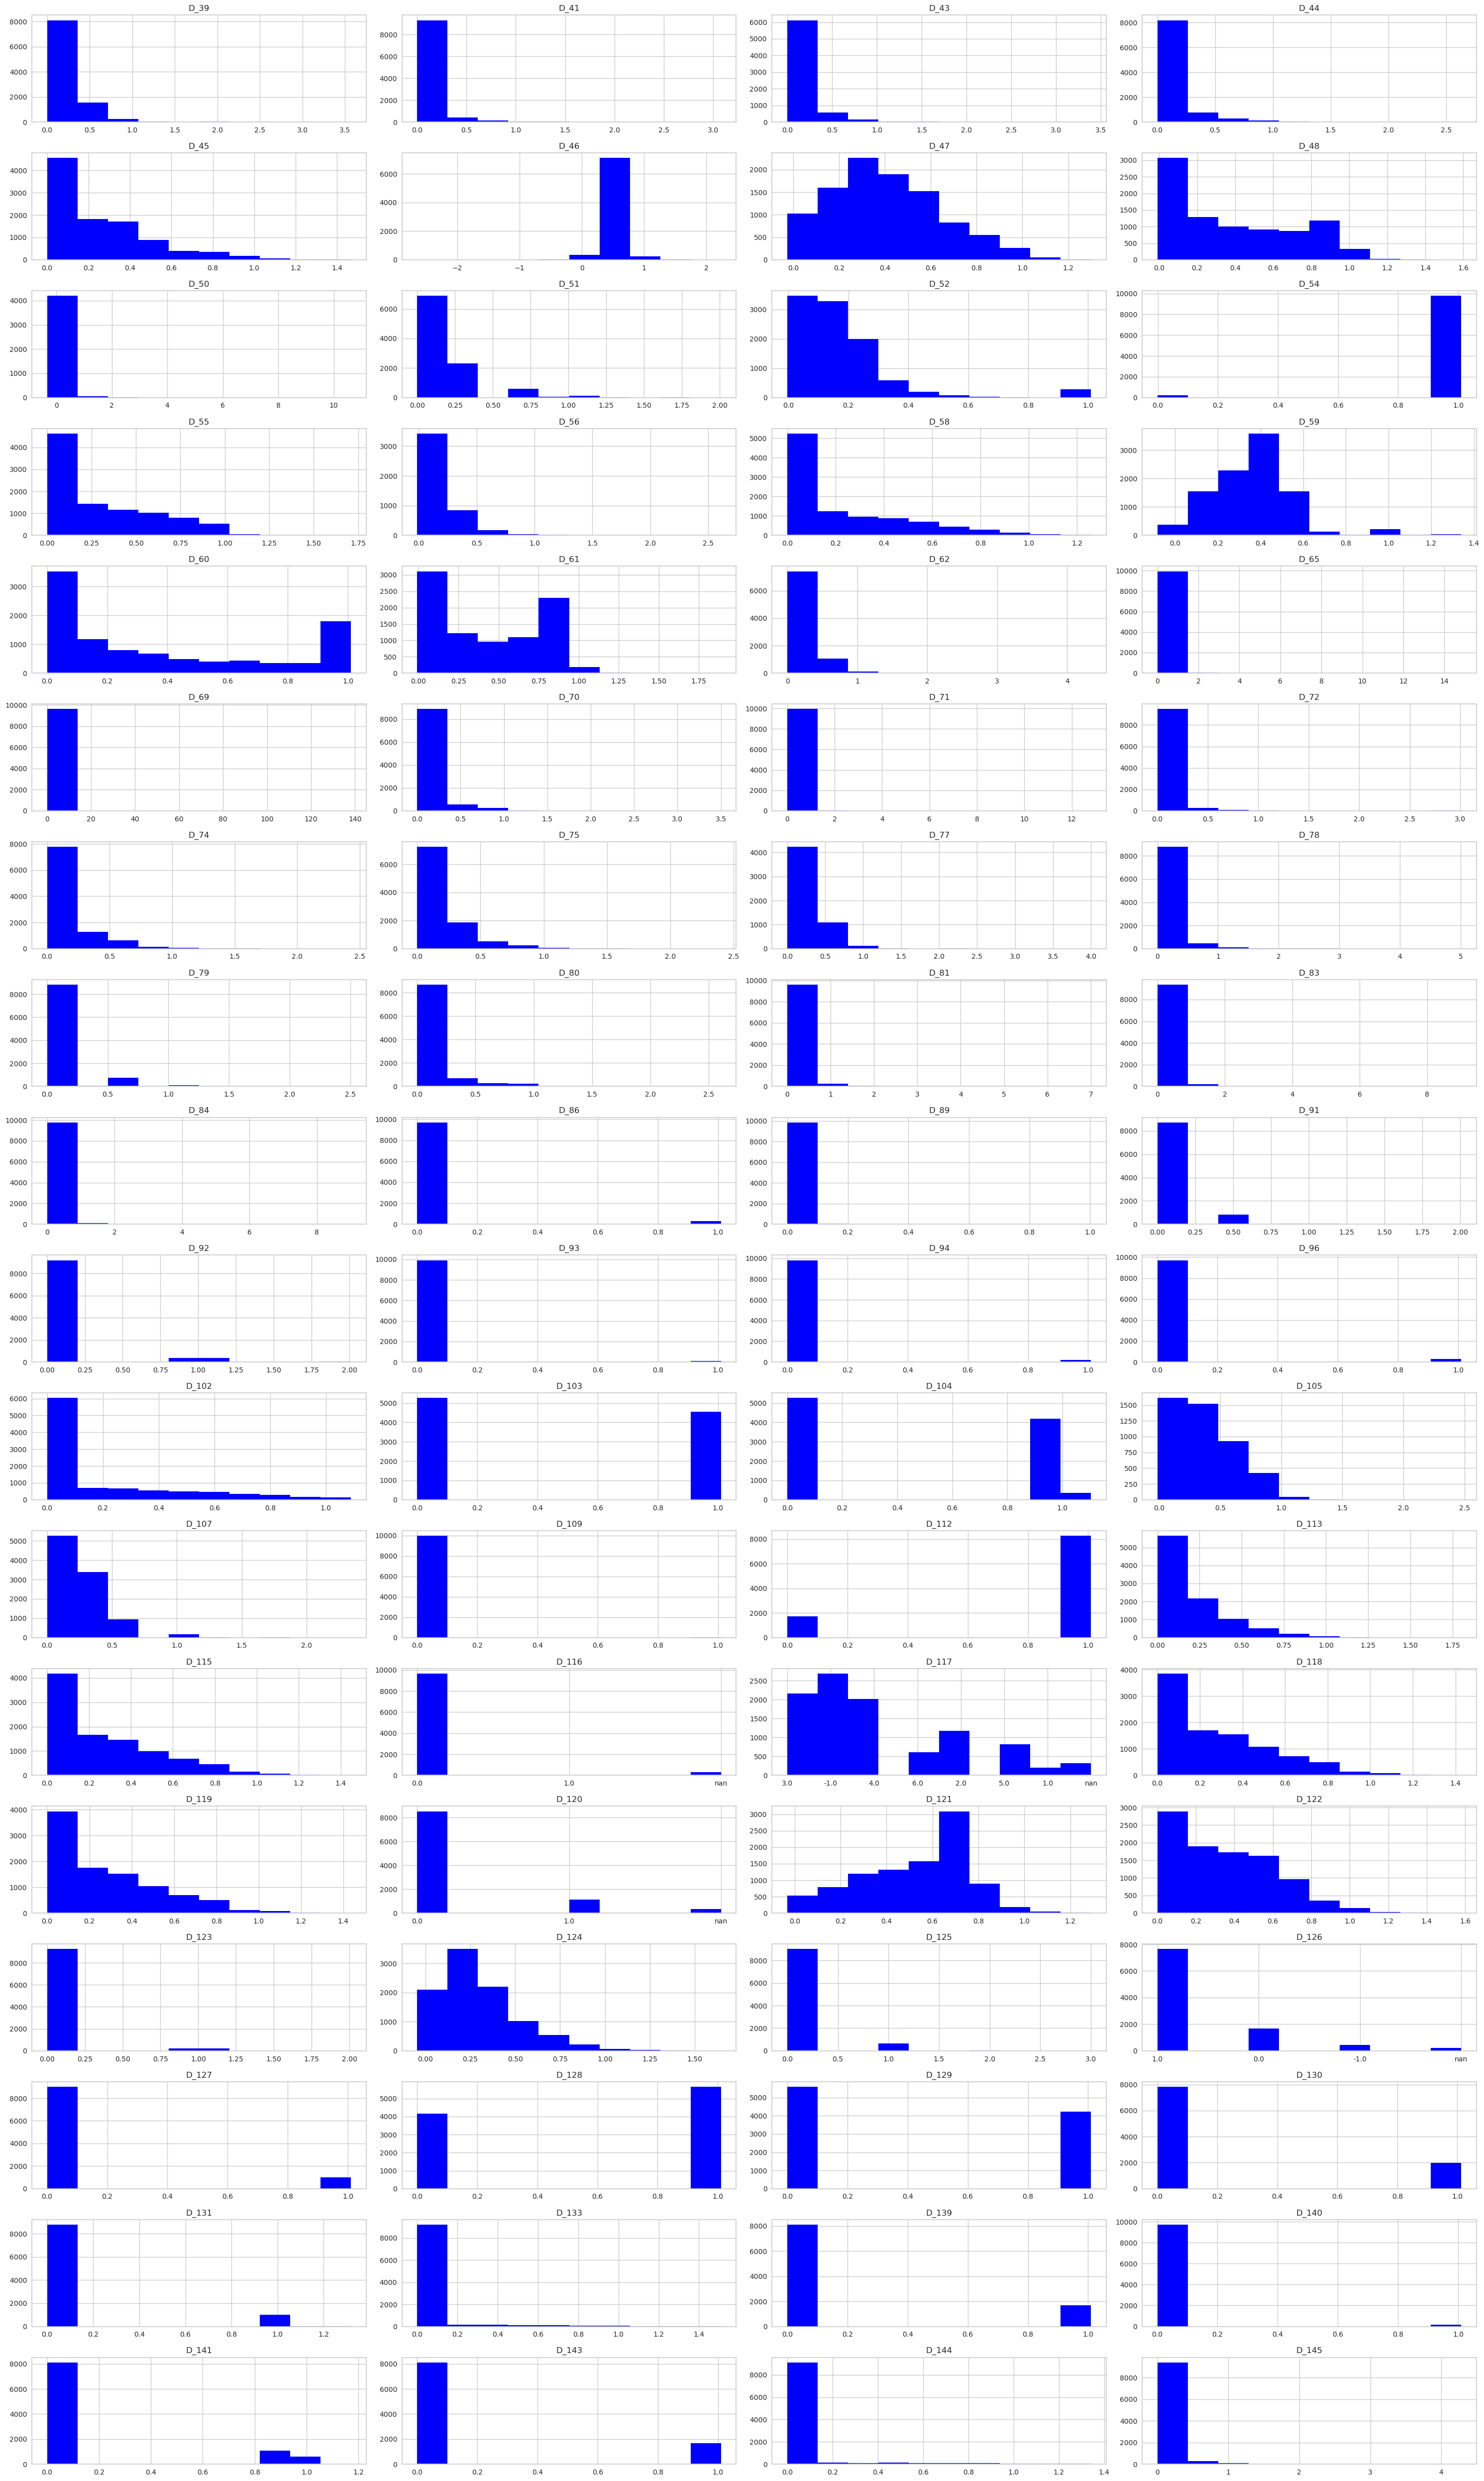

In [46]:
#Ploaxlabelt distributions for D variables (ones that dont have >=70% NANs)
nrows=18
ncols=4
fig, axes = plt.subplots(nrows, ncols, figsize=(30,50)) 
d_columns= ['D_39', 'D_41', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_52', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62','D_65','D_69', 'D_70', 'D_71', 'D_72', 'D_74', 'D_75', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_83', 'D_84', 'D_86', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96','D_102', 'D_103', 'D_104', 'D_105', 'D_107', 'D_109', 'D_112', 'D_113','D_115', 'D_116', 'D_117','D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125','D_126','D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_133', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145']
axes = axes.flatten()   
df_train_sample = df_train.sample(frac =.1)
for ax,col in zip(axes,d_columns):
    ax.hist(df_train_sample[col],color="blue")
    ax.set_title(col)
    
plt.tight_layout()

**Observation:**

* Above plot shows distribution for D variables and skewness in distribution. There are many variables which appear to be having extreme end value which are essentially binary variables (1 or 0). We also can definitely see some skewness in some distributions as well as possibly normal distributions. Overall, a decent variety of possible distributions which is interesting.

Few joint distributions of correlated variables:
    

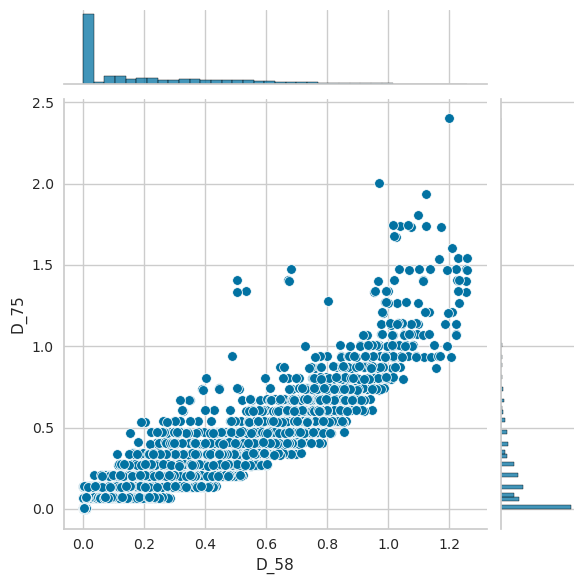

In [47]:
#Joint Distribution for D_58 and D_75
sns.jointplot(data=df_train_sample,x='D_58',y='D_75')

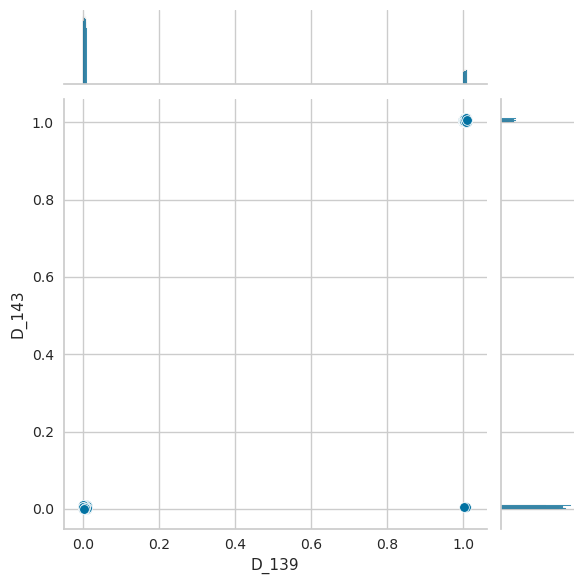

In [48]:
#Joint Distribution for D_139 and D_143
sns.jointplot(data=df_train_sample,x='D_139',y='D_143')

## S_* = Spend variables

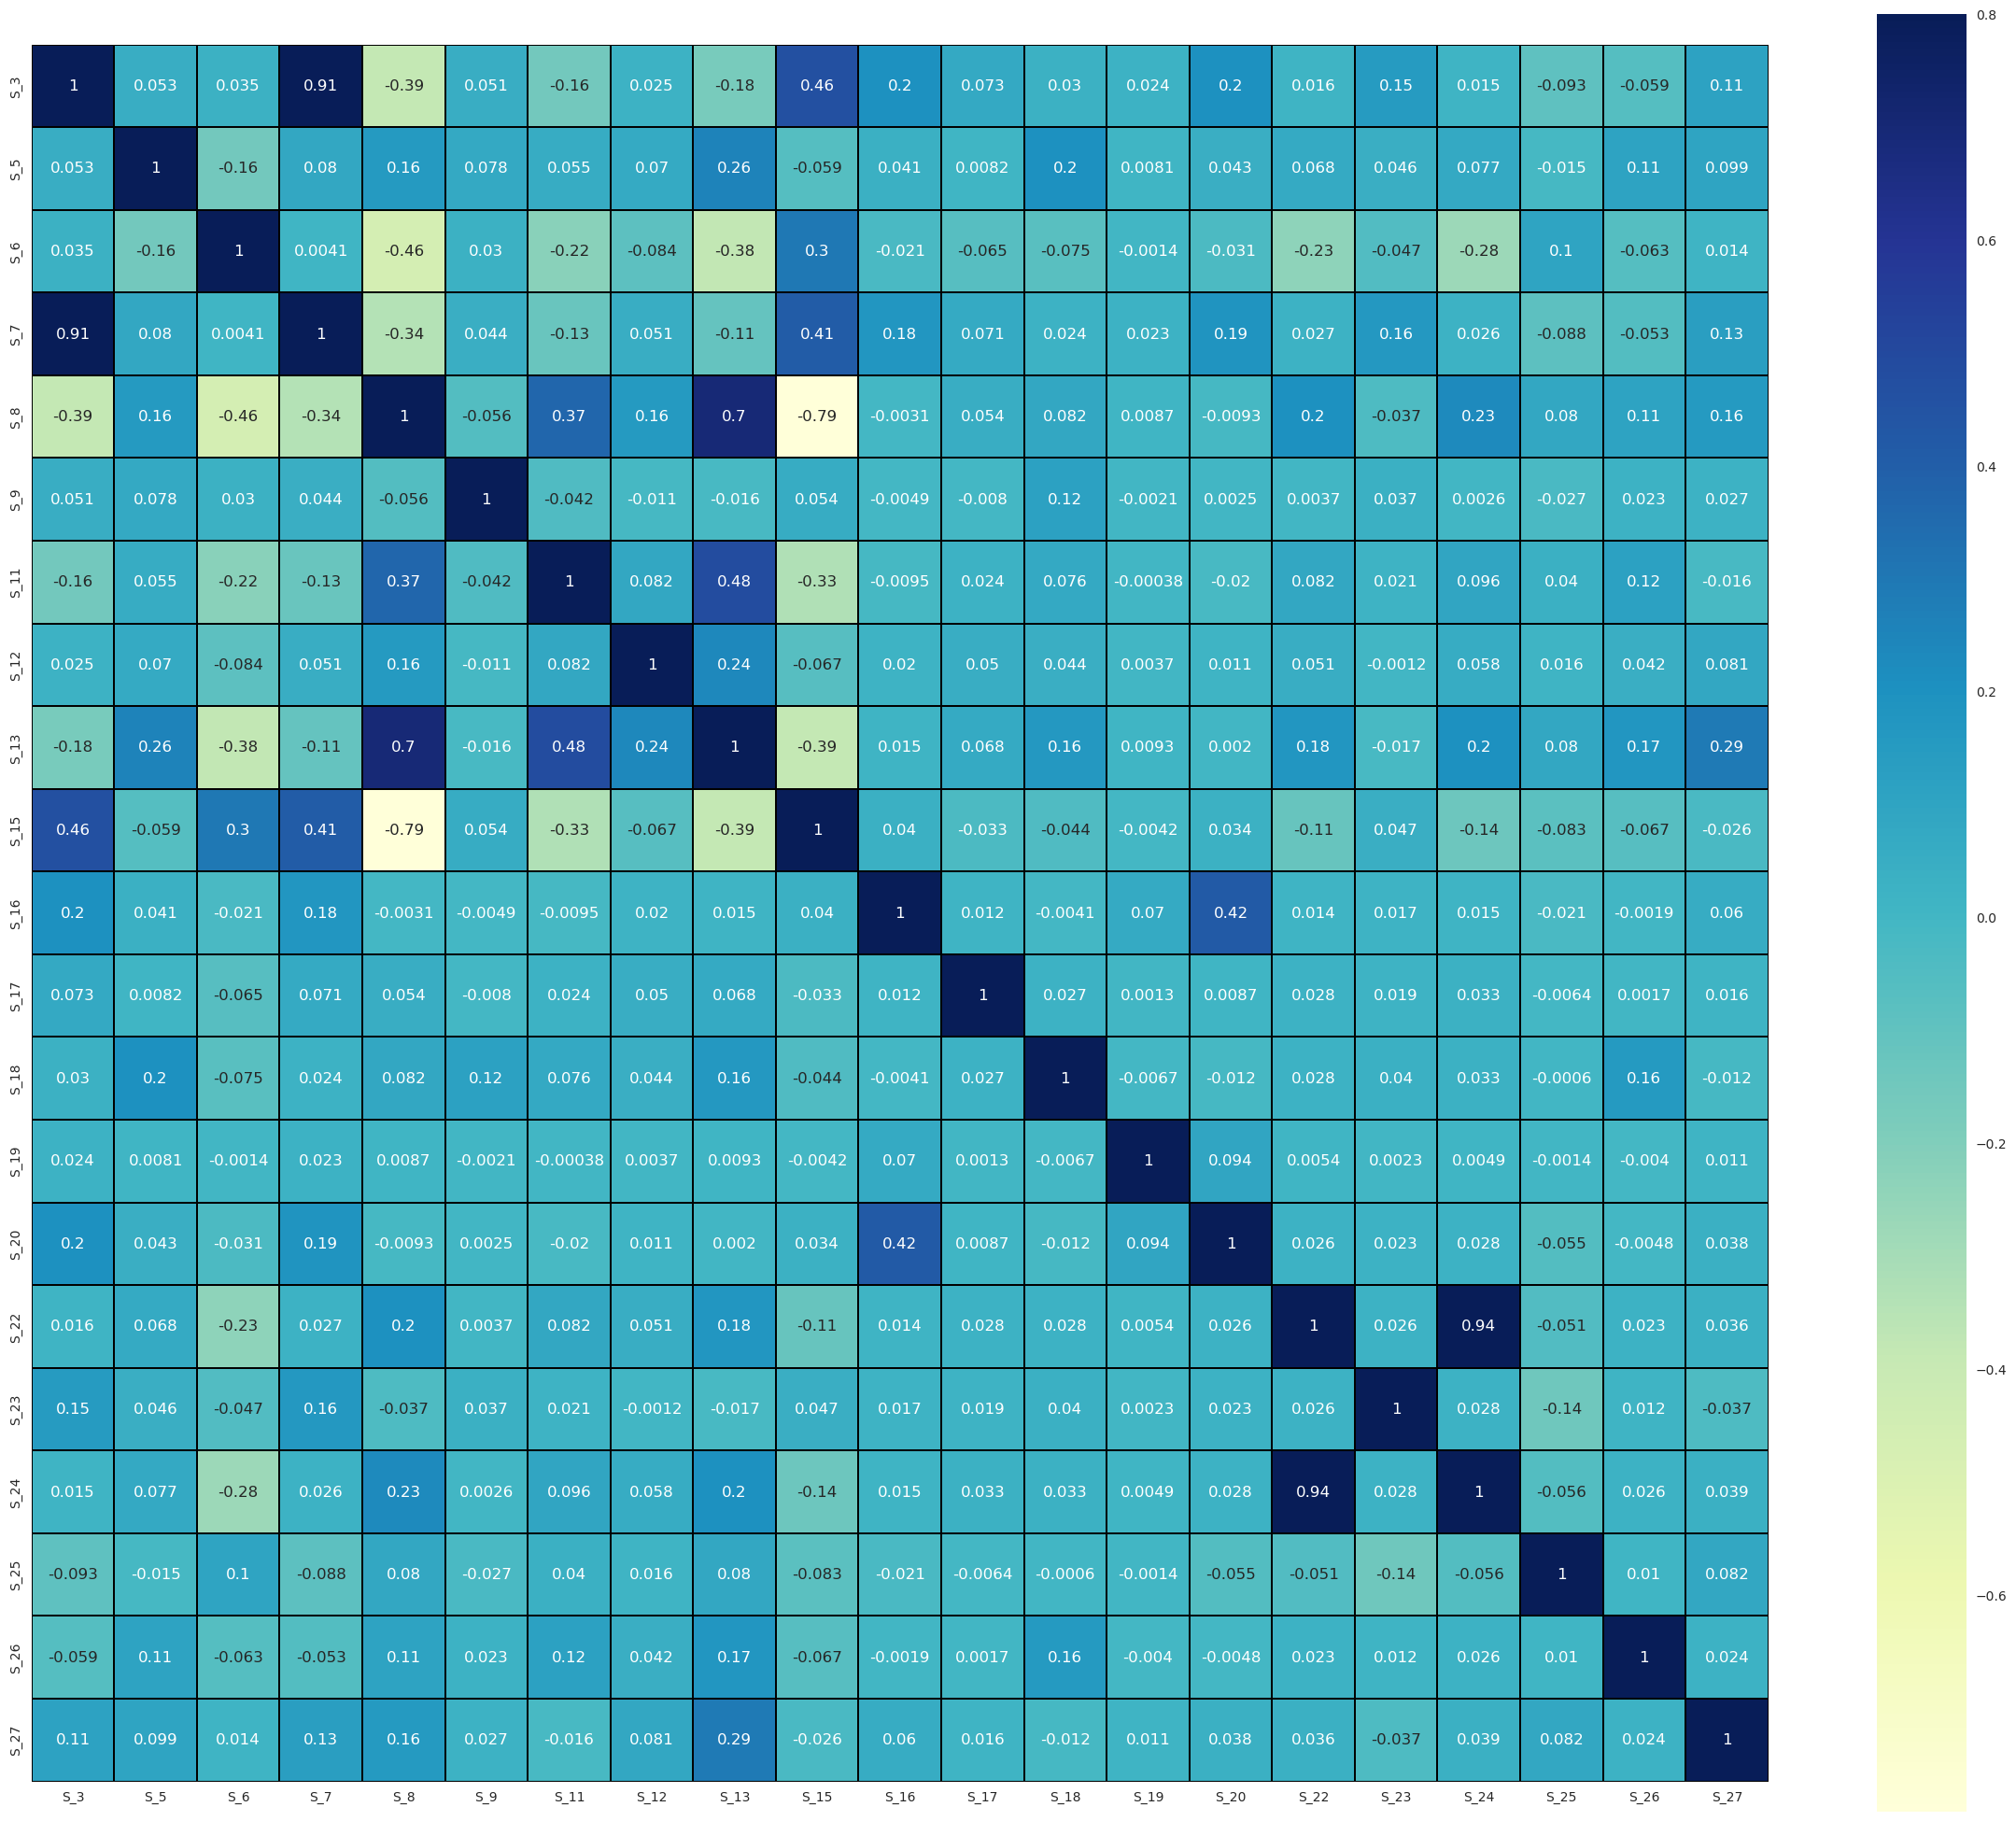

In [49]:
#Plot correlation between S variables
corr = df_train[S_columns].corr(method='pearson')
plt.figure(figsize=(30,25))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.show()

**Observation:**

* S_3 has correlation of 0.91 with S_7
* S_22 has correlation of 0.94 with S_24

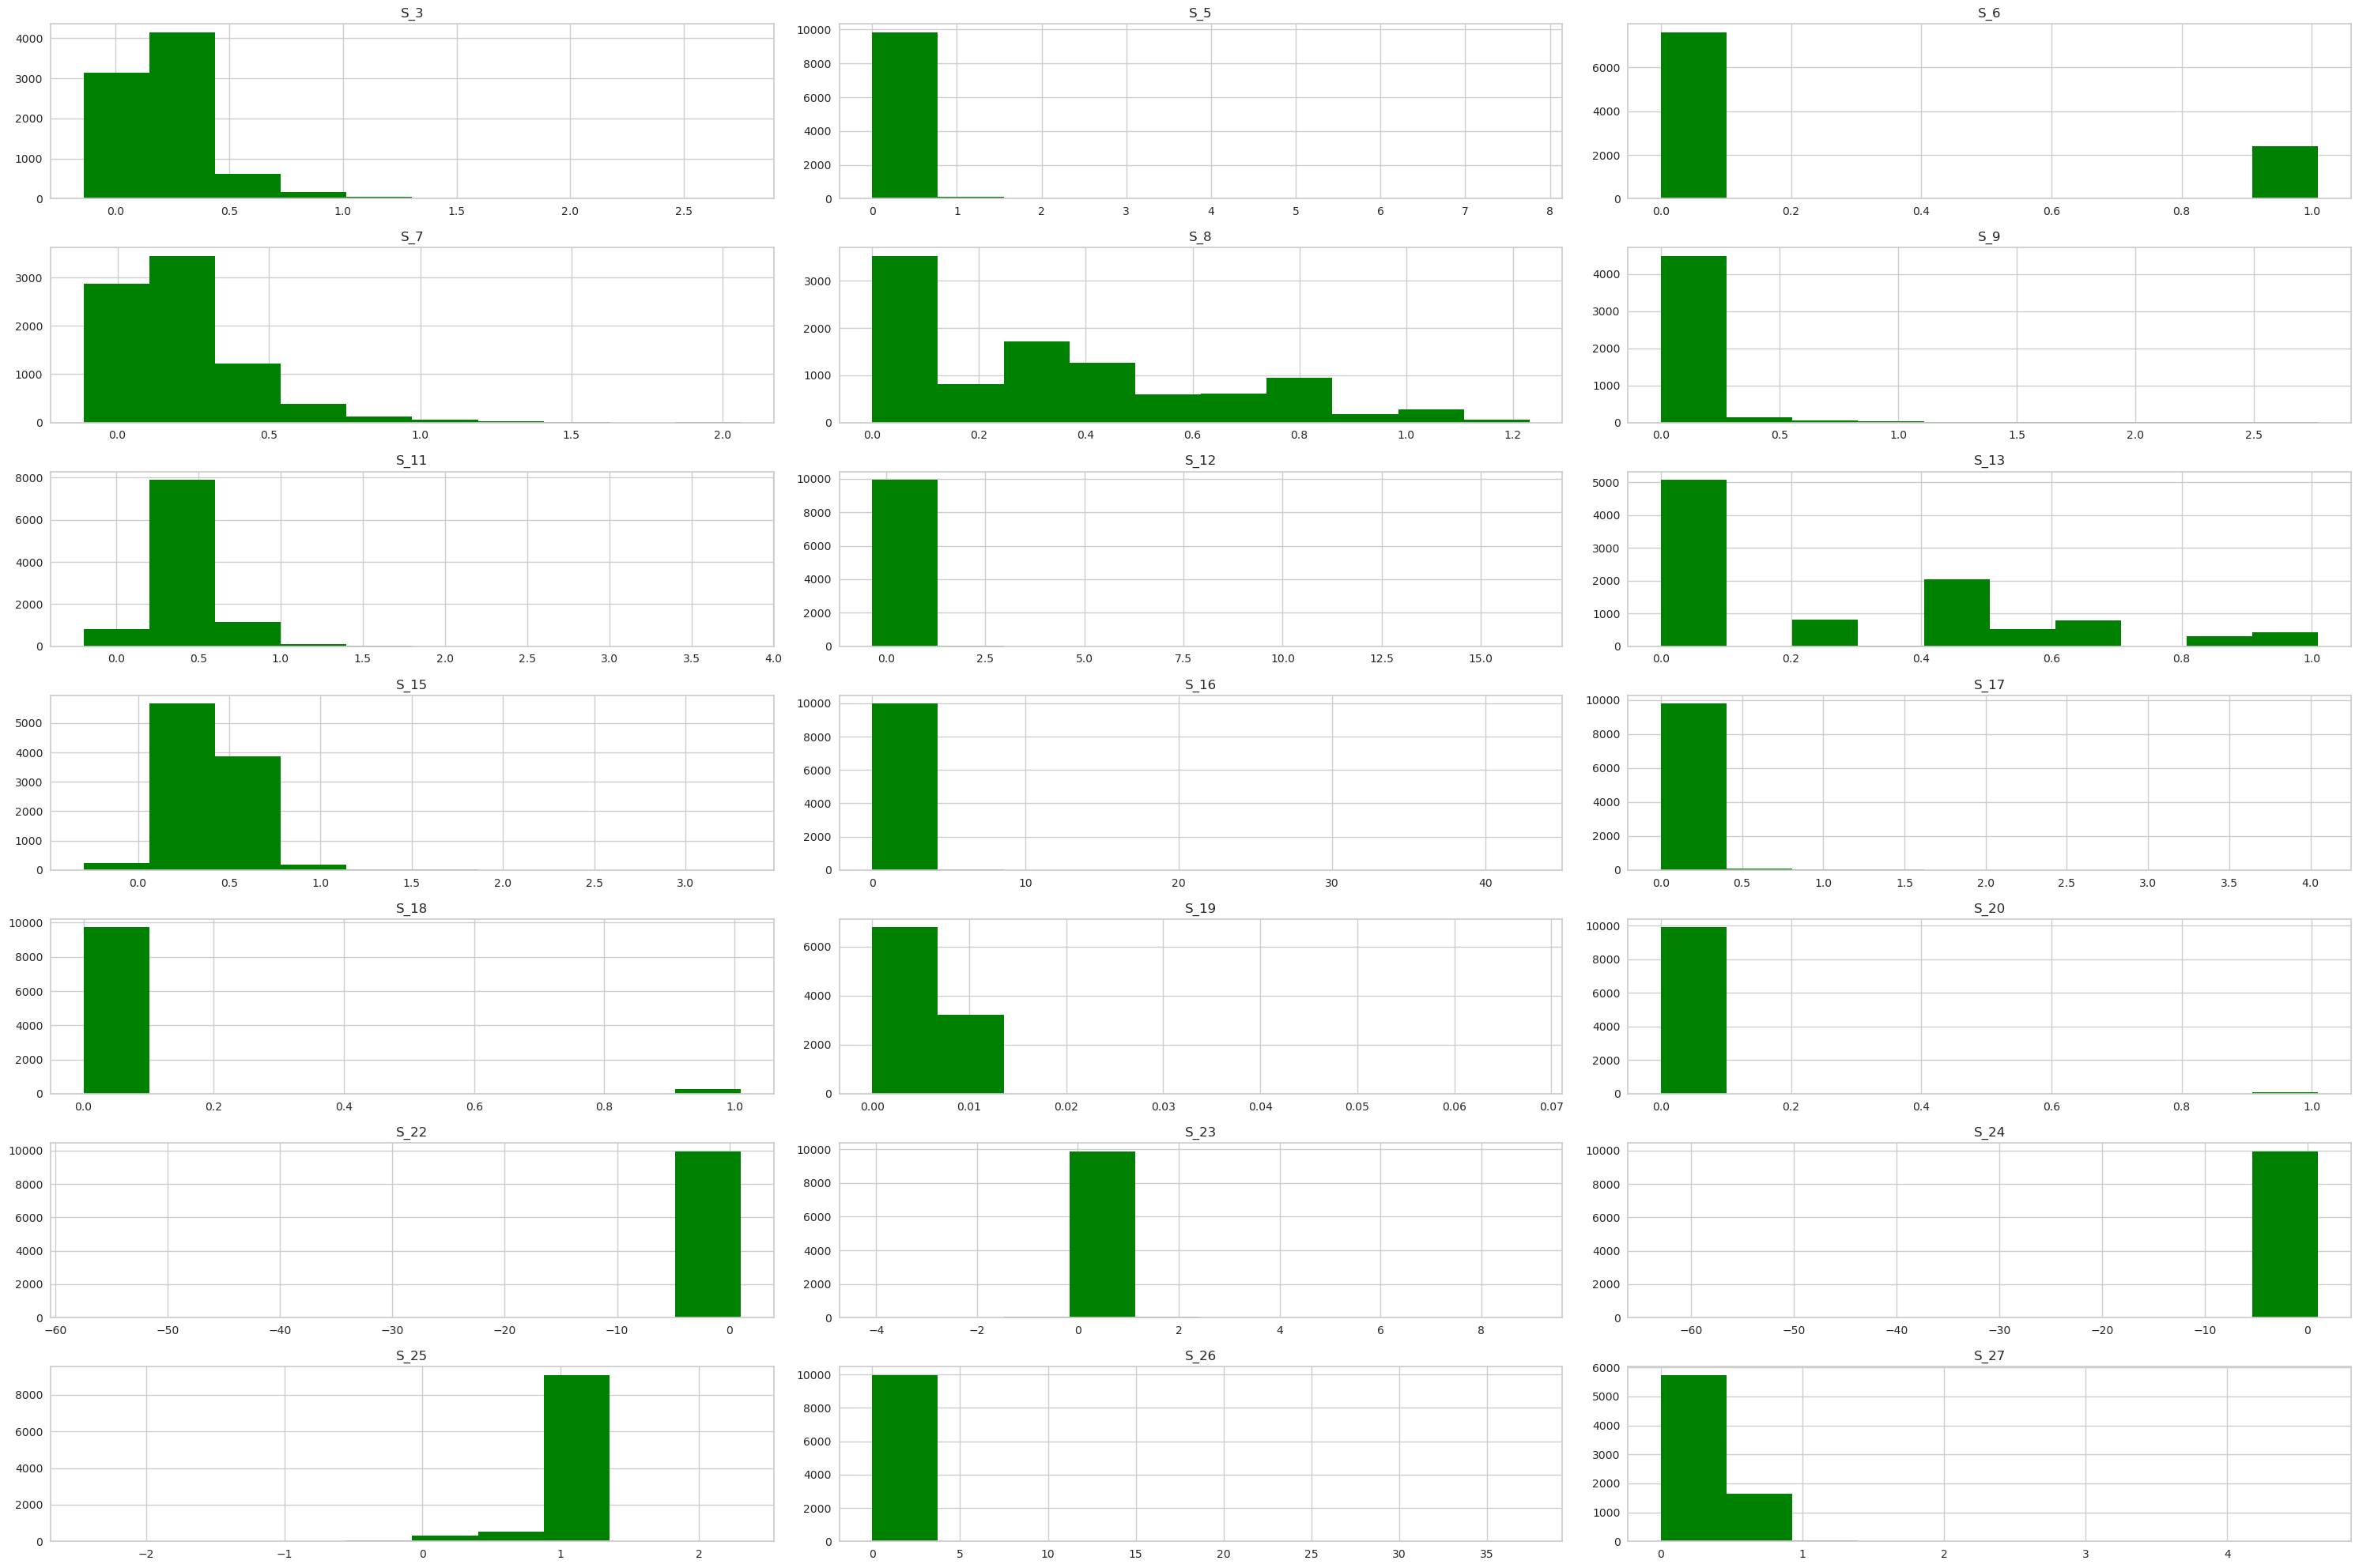

In [50]:
#Plot distributions for S variables
fig, axes = plt.subplots(nrows = 7, ncols = 3, figsize=(30,20)) 
s_columns =['S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
axes = axes.flatten()   
train_df_sample = df_train.sample(frac =.1)
for ax,col in zip(axes,s_columns):
    ax.hist(train_df_sample[col], color="green")
    ax.set_title(col)
    
plt.tight_layout()

**Observation:**

* Again, we have a good mixture of distributions similar to the D variables.

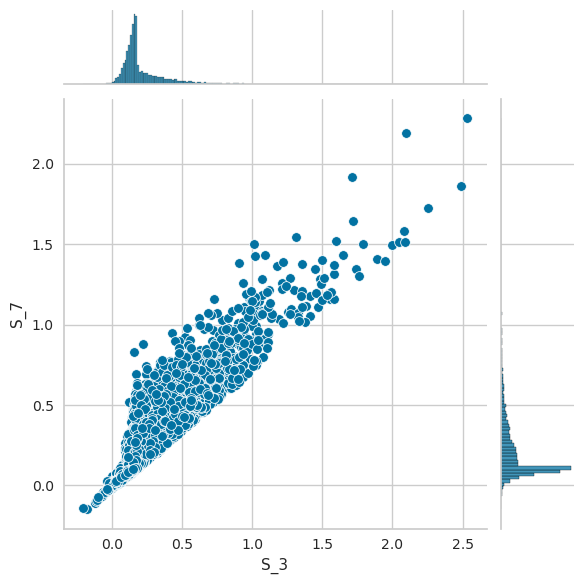

In [51]:
#Joint Distribution for S_3 and S_7
sns.jointplot(data=df_train_sample,x='S_3',y='S_7')

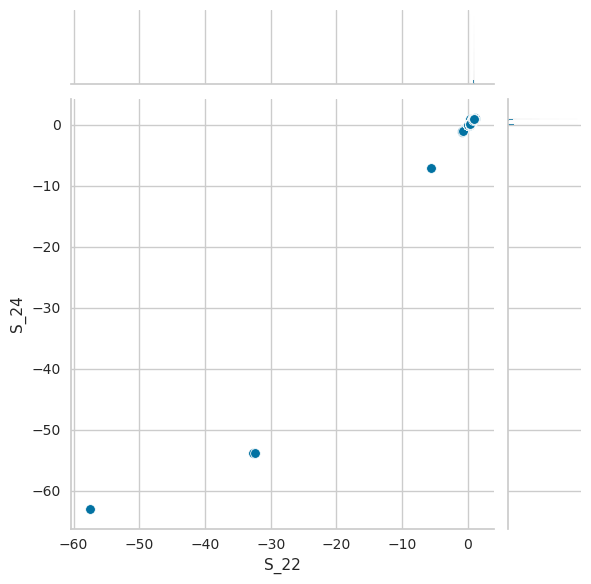

In [52]:
#Joint Distribution for S_22 and S_24
sns.jointplot(data=df_train_sample,x='S_22',y='S_24')

## P_* = Payment variables

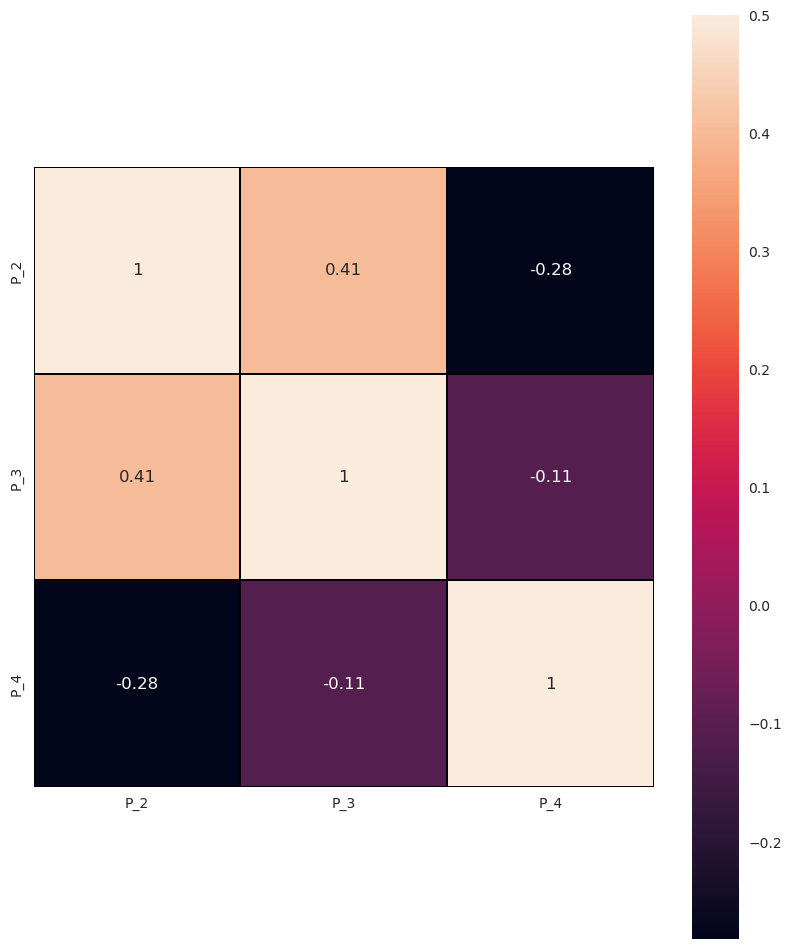

In [53]:
#Plot correlation between P variables
corr = df_train[P_columns].corr(method='pearson')
plt.figure(figsize=(10,12))
sns.heatmap(corr,vmax=.5,linewidth=.01, square = True, annot = True,linecolor ='black')
plt.show()

**Observation:**

* None of the P variables appear to be highly correlated.

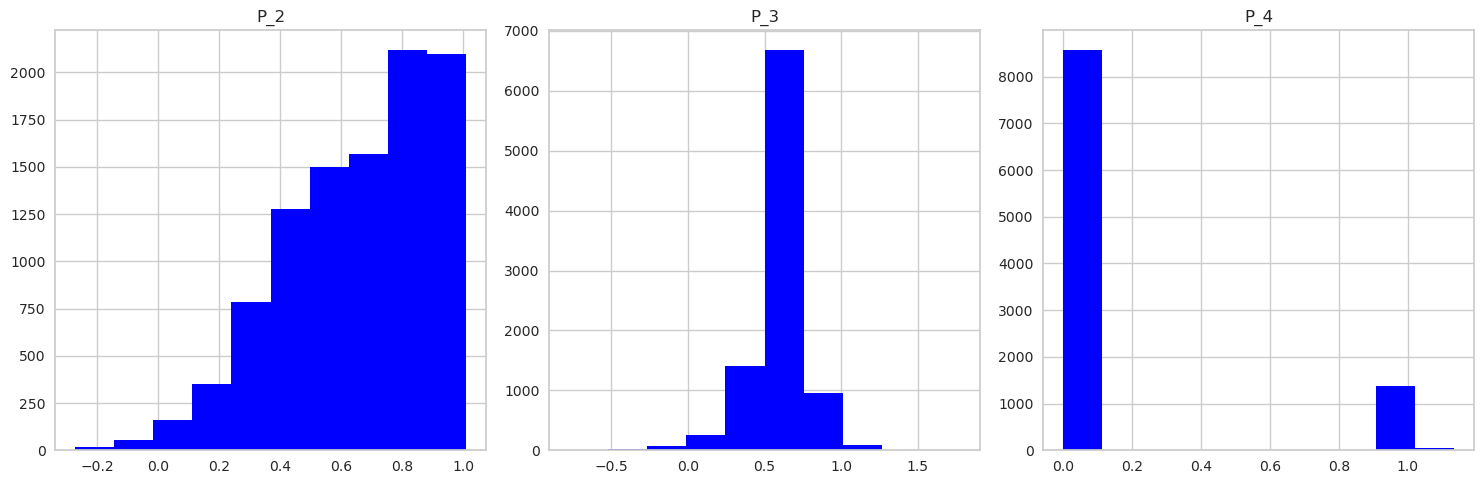

In [54]:
#Plot distribution for P variables
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5)) 
axes = axes.flatten()   
train_df_sample = df_train.sample(frac =.1)
for ax,col in zip(axes,P_columns):
    ax.hist(train_df_sample[col], color="blue")
    ax.set_title(col)
    
plt.tight_layout()

**Observation:**

* P_2 variable appears to have negative skewed distribution (longer left tail)
* P_3 variable appears to have normal distribution
* P_4 variable appears to have bimodal distribution

## B_* = Balance variables

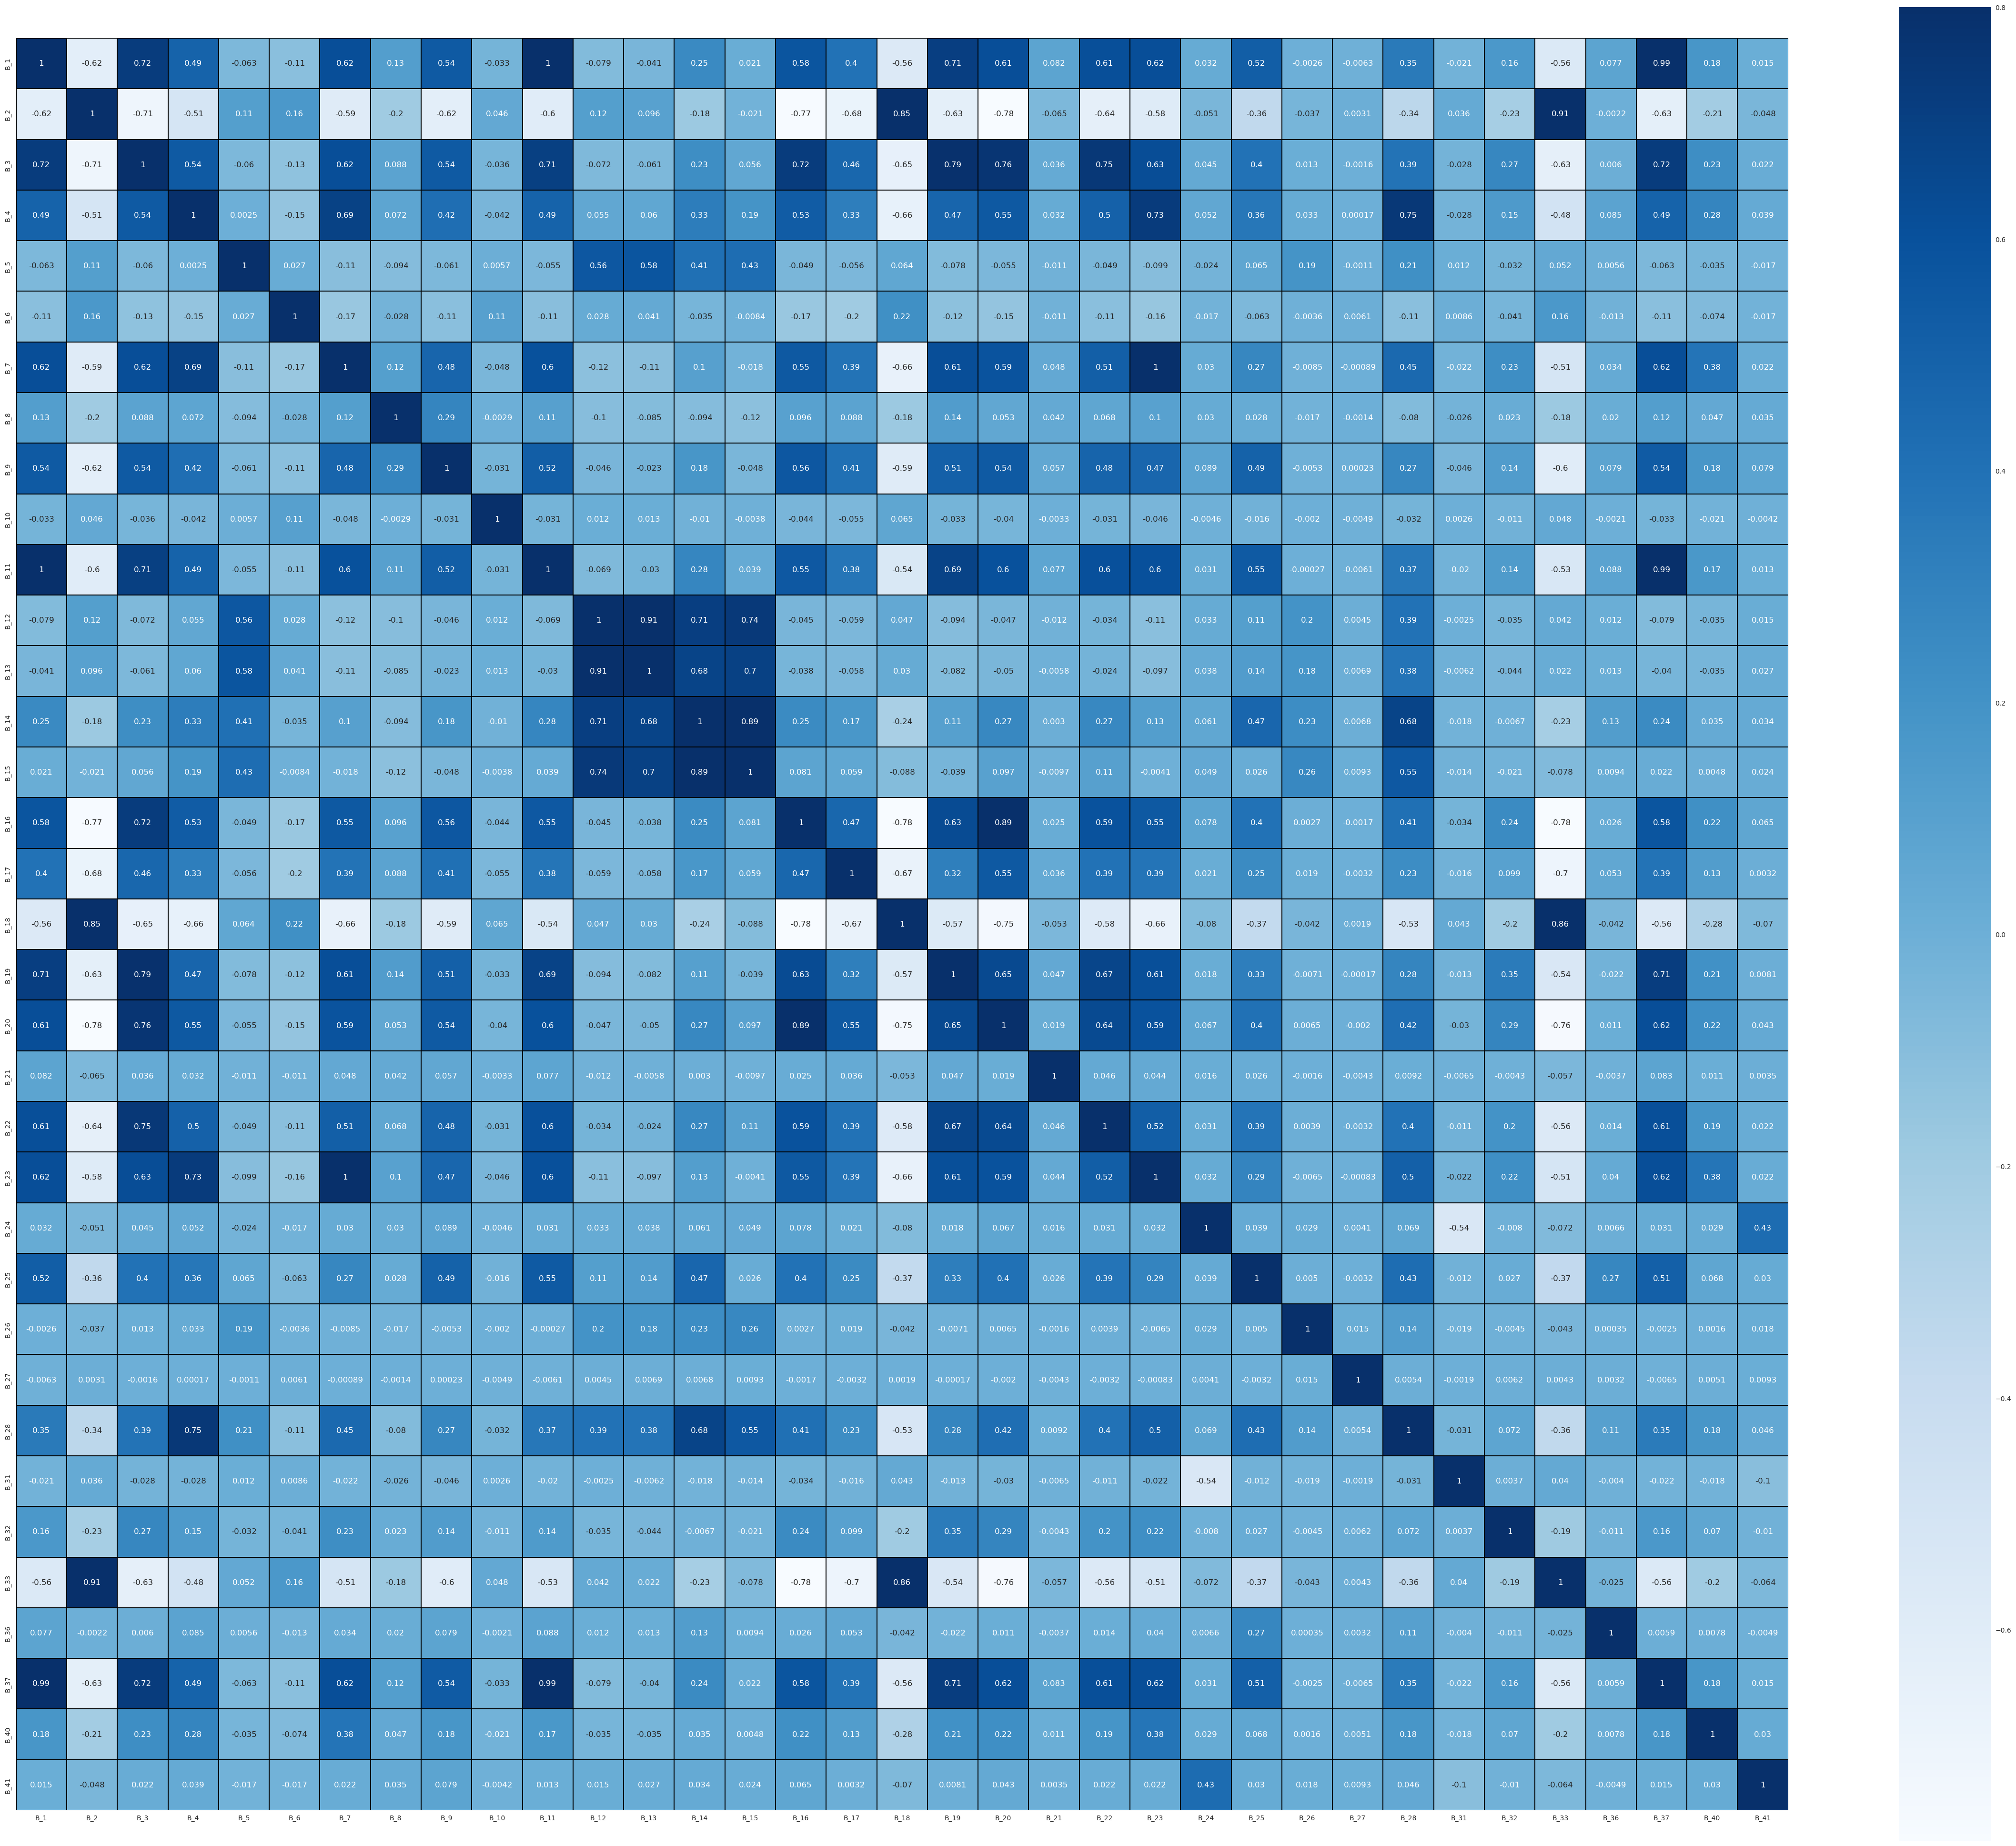

In [55]:
#Plot correlation between B variables
corr = df_train[B_columns].corr(method='pearson')
plt.figure(figsize=(60,50))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='Blues',linecolor ='black')
plt.show()

**Highest Correlations among B_ variables:**

* B_1 has correlation of 0.99 with B_37
* B_1 has correlation of 1.0 with B_11
* B_2 has correlation of 0.91 with B_33
* B_11 has correlation of 0.99 with B_37
* B_7 has correlation of 1.0 with B_23

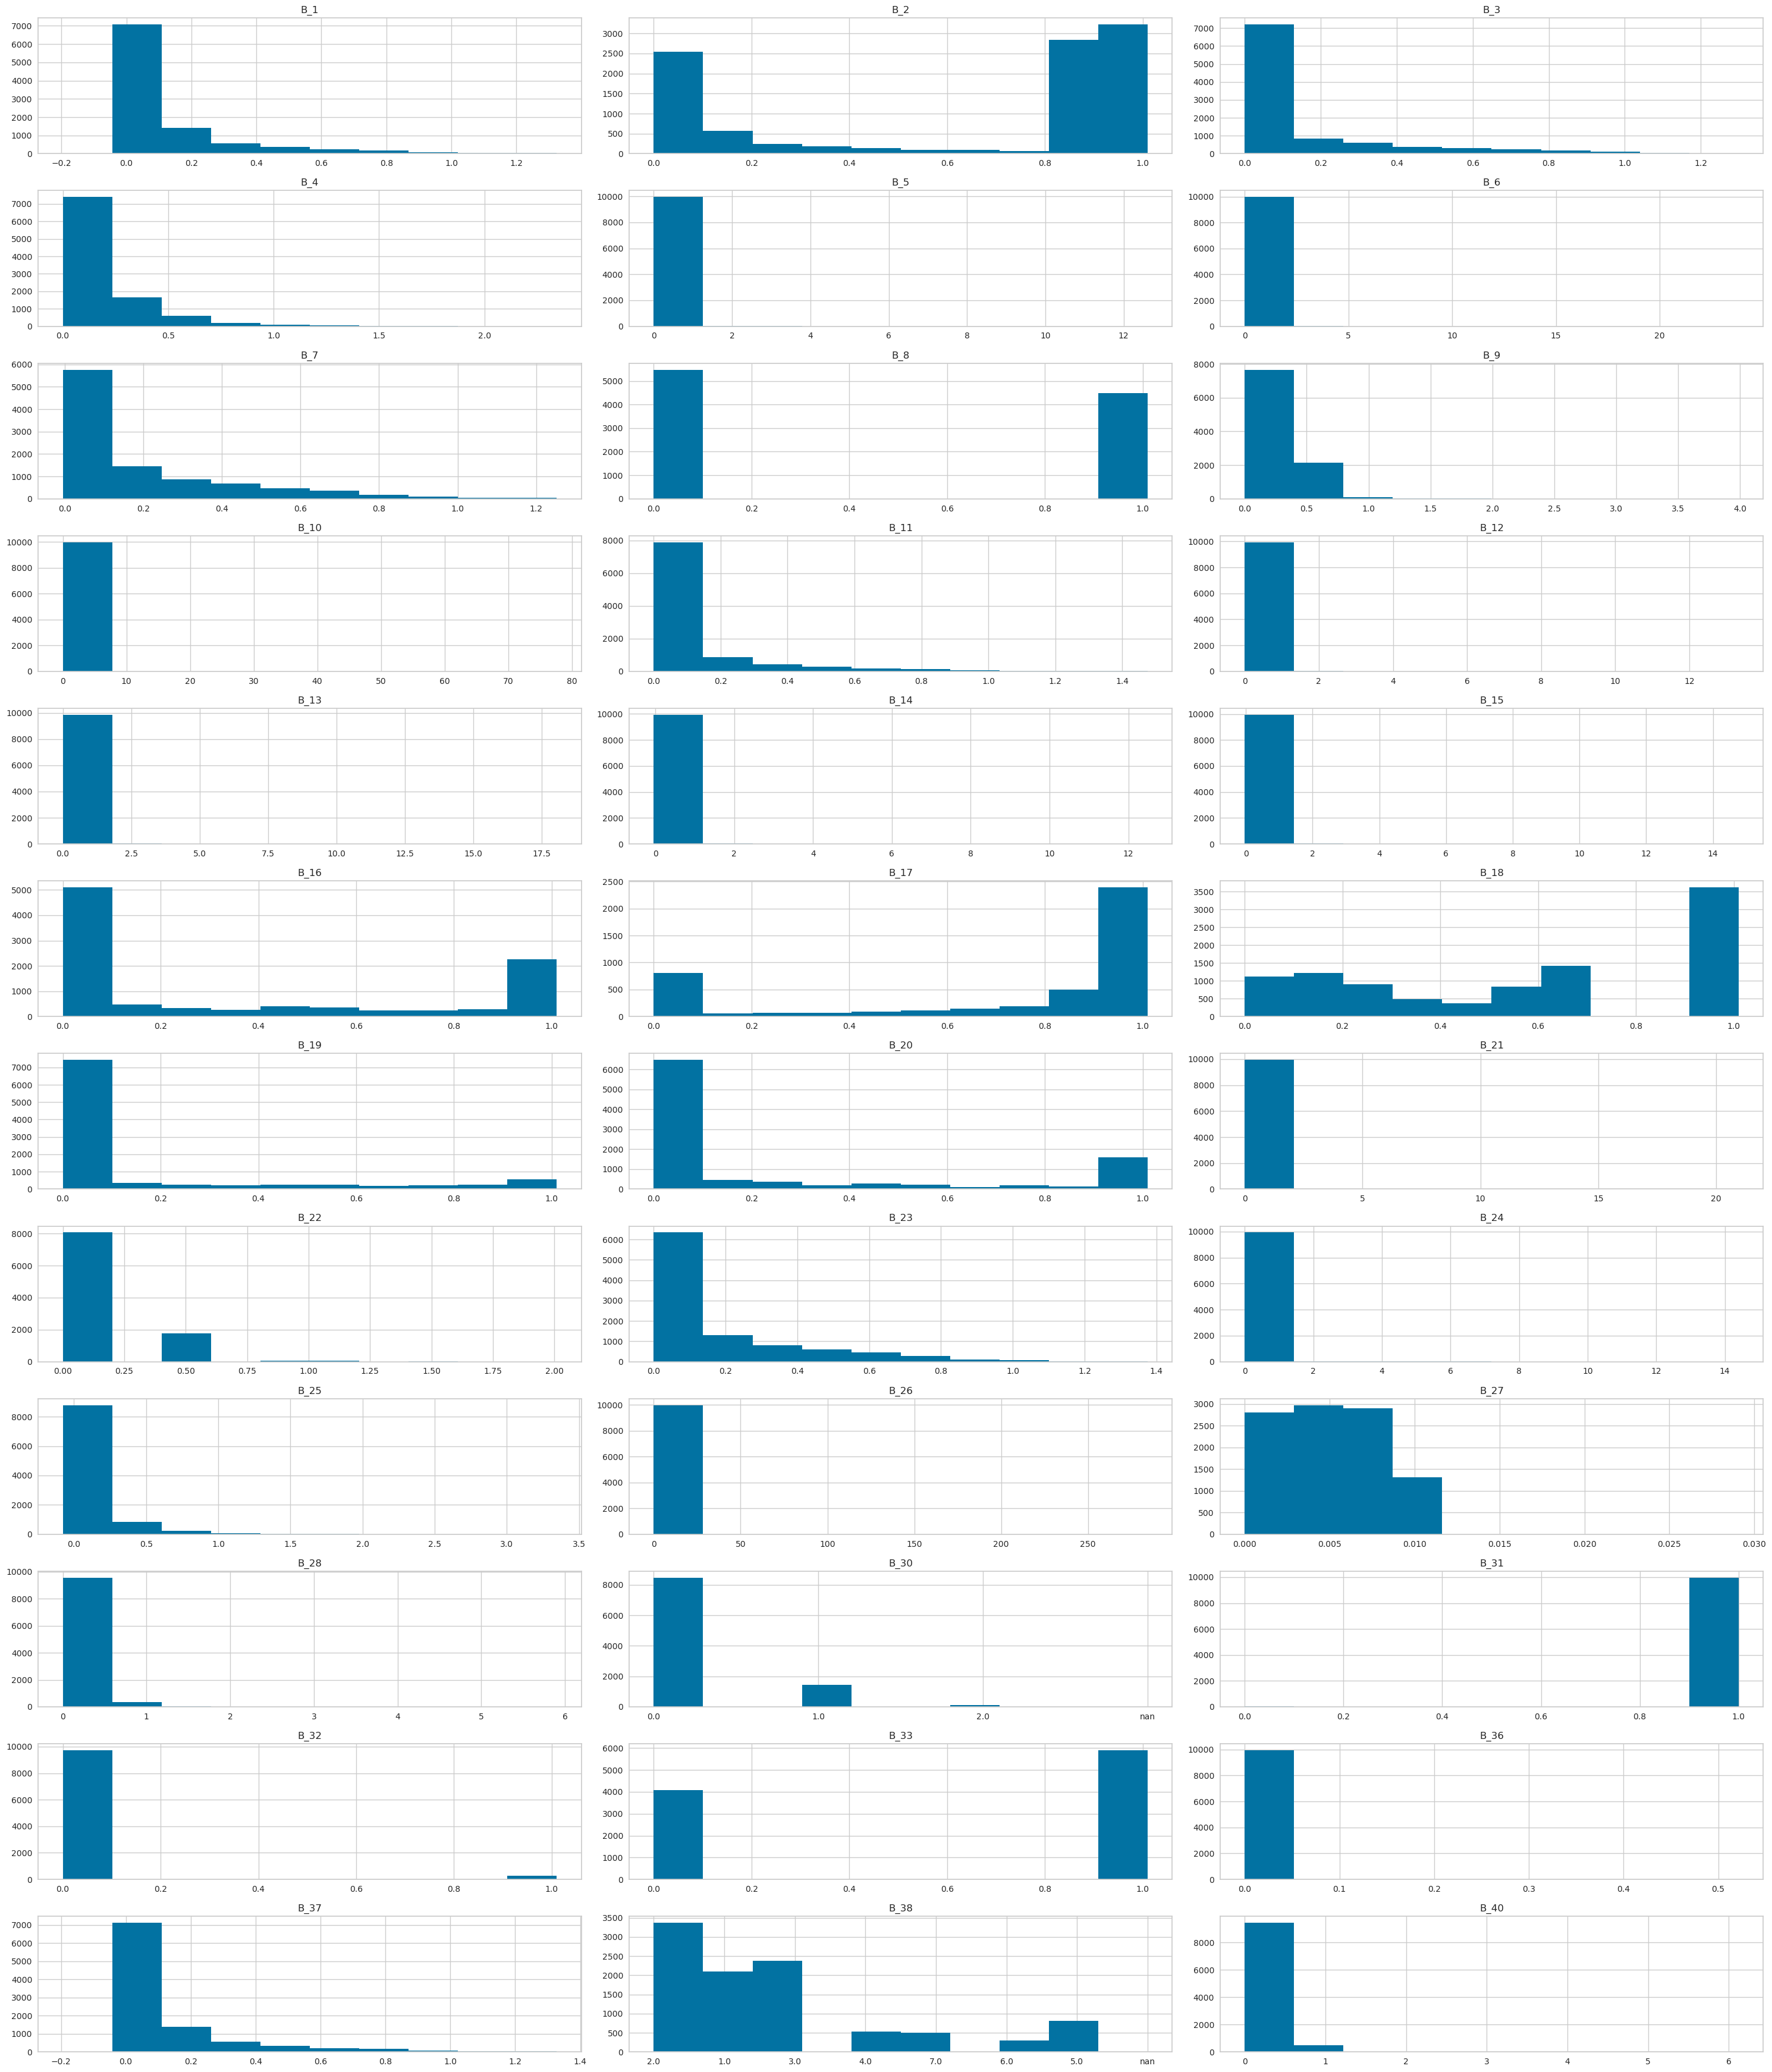

In [56]:
#Plot distribution for B variables
fig, axes = plt.subplots(nrows = 12, ncols = 3, figsize=(30,35)) 
axes = axes.flatten()   
train_df_sample = df_train.sample(frac =.1)
for ax,col in zip(axes,B_columns):
    ax.hist(train_df_sample[col],color="b")
    ax.set_title(col)
    
plt.tight_layout()

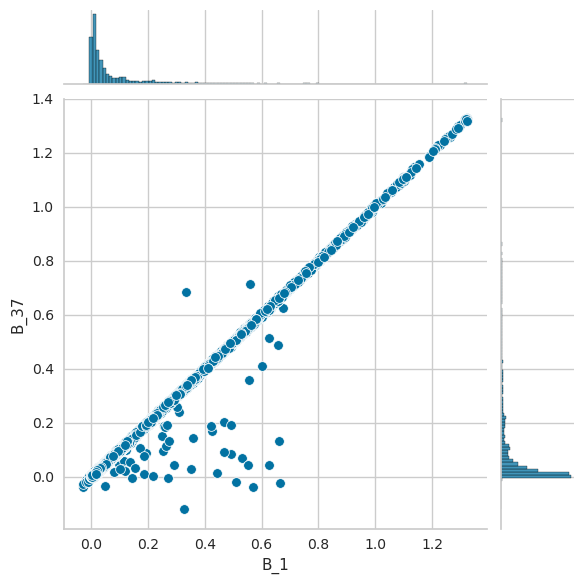

In [57]:
#Joint Distribution for B_1 and B_37
sns.jointplot(data=df_train_sample,x='B_1',y='B_37')

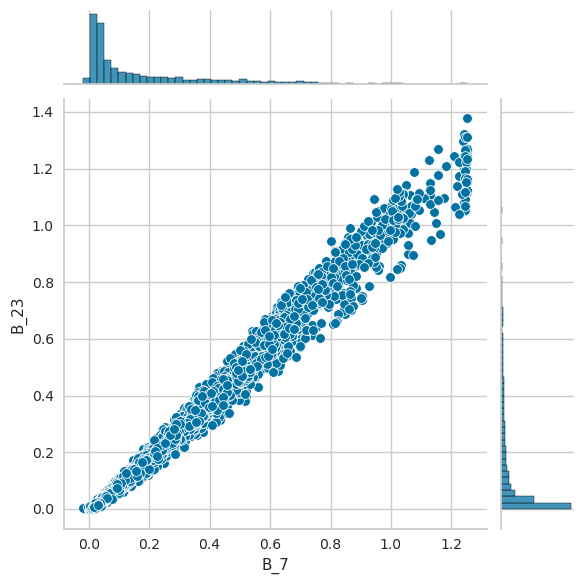

In [58]:
#Joint Distribution for B_7 and B_23
sns.jointplot(data=df_train_sample,x='B_7',y='B_23')

## R_* = Risk variables

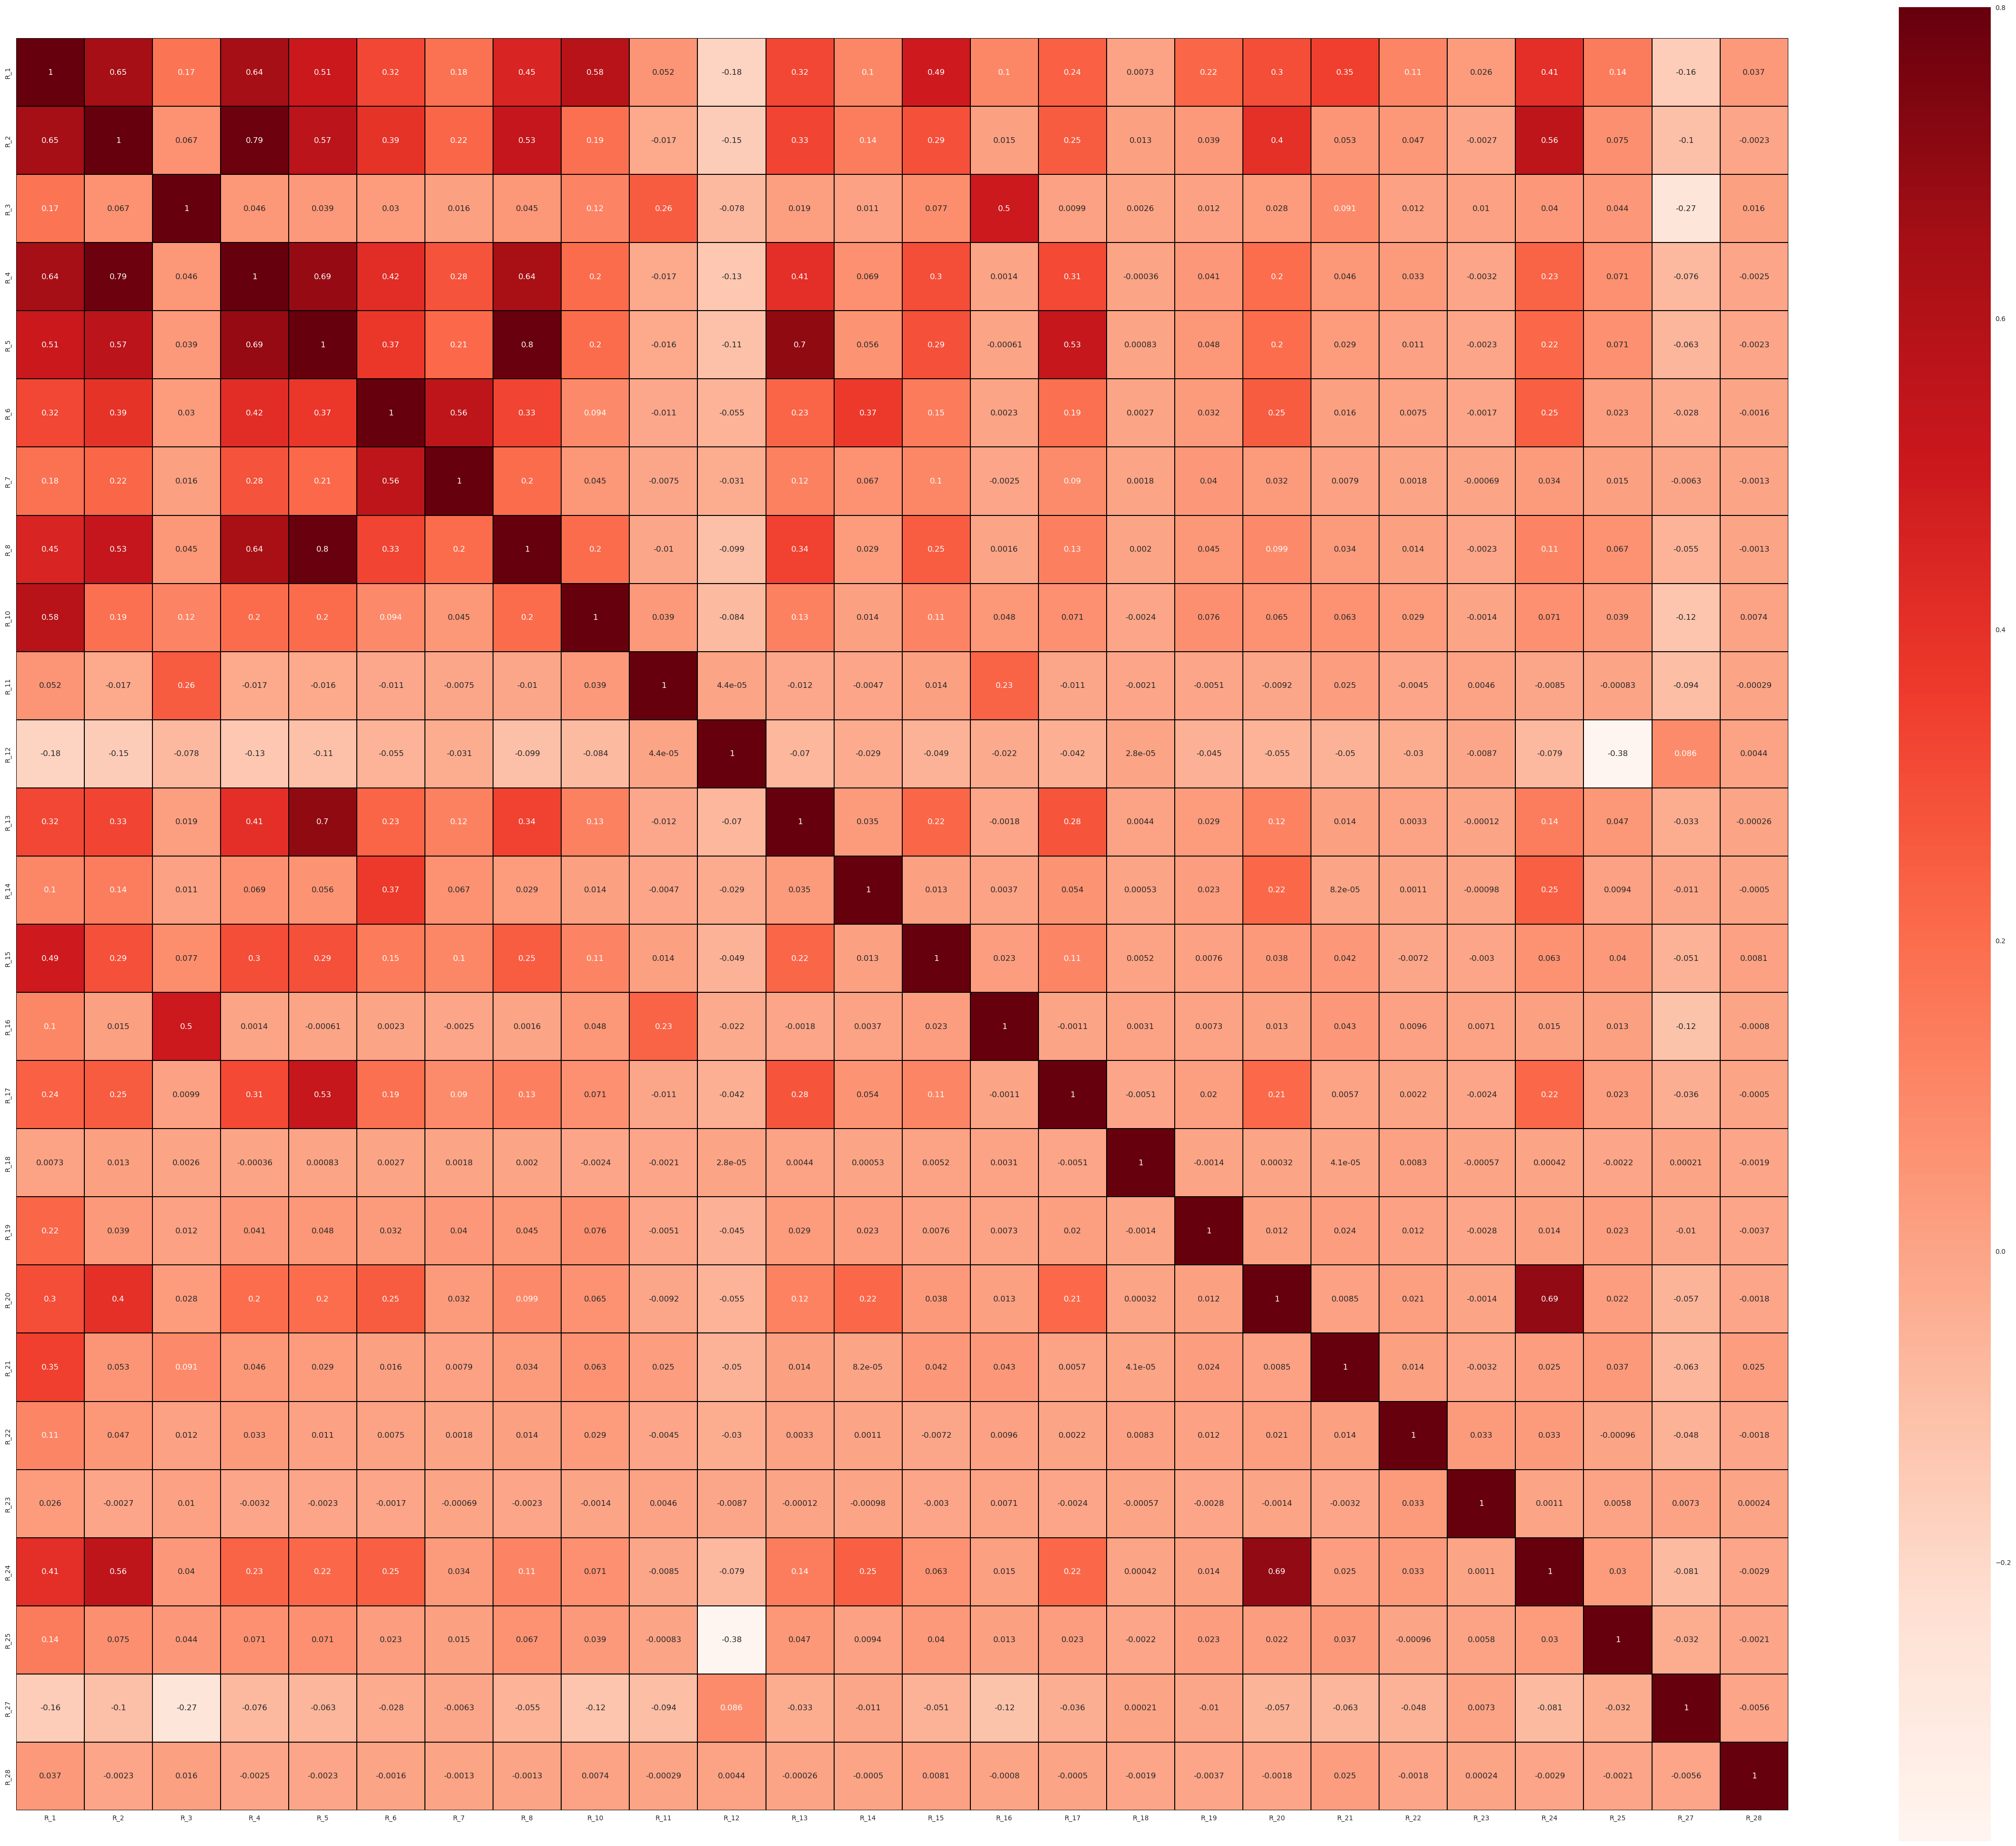

In [60]:
#Plot correlation between R variables
corr = df_train[R_columns].corr(method='pearson')
plt.figure(figsize=(60,50))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='Reds',linecolor ='black')
plt.show()

**Observation:**

* R_4 has correlation of 0.79 with R_2
* R_5 has correlation of 0.8 with R_8

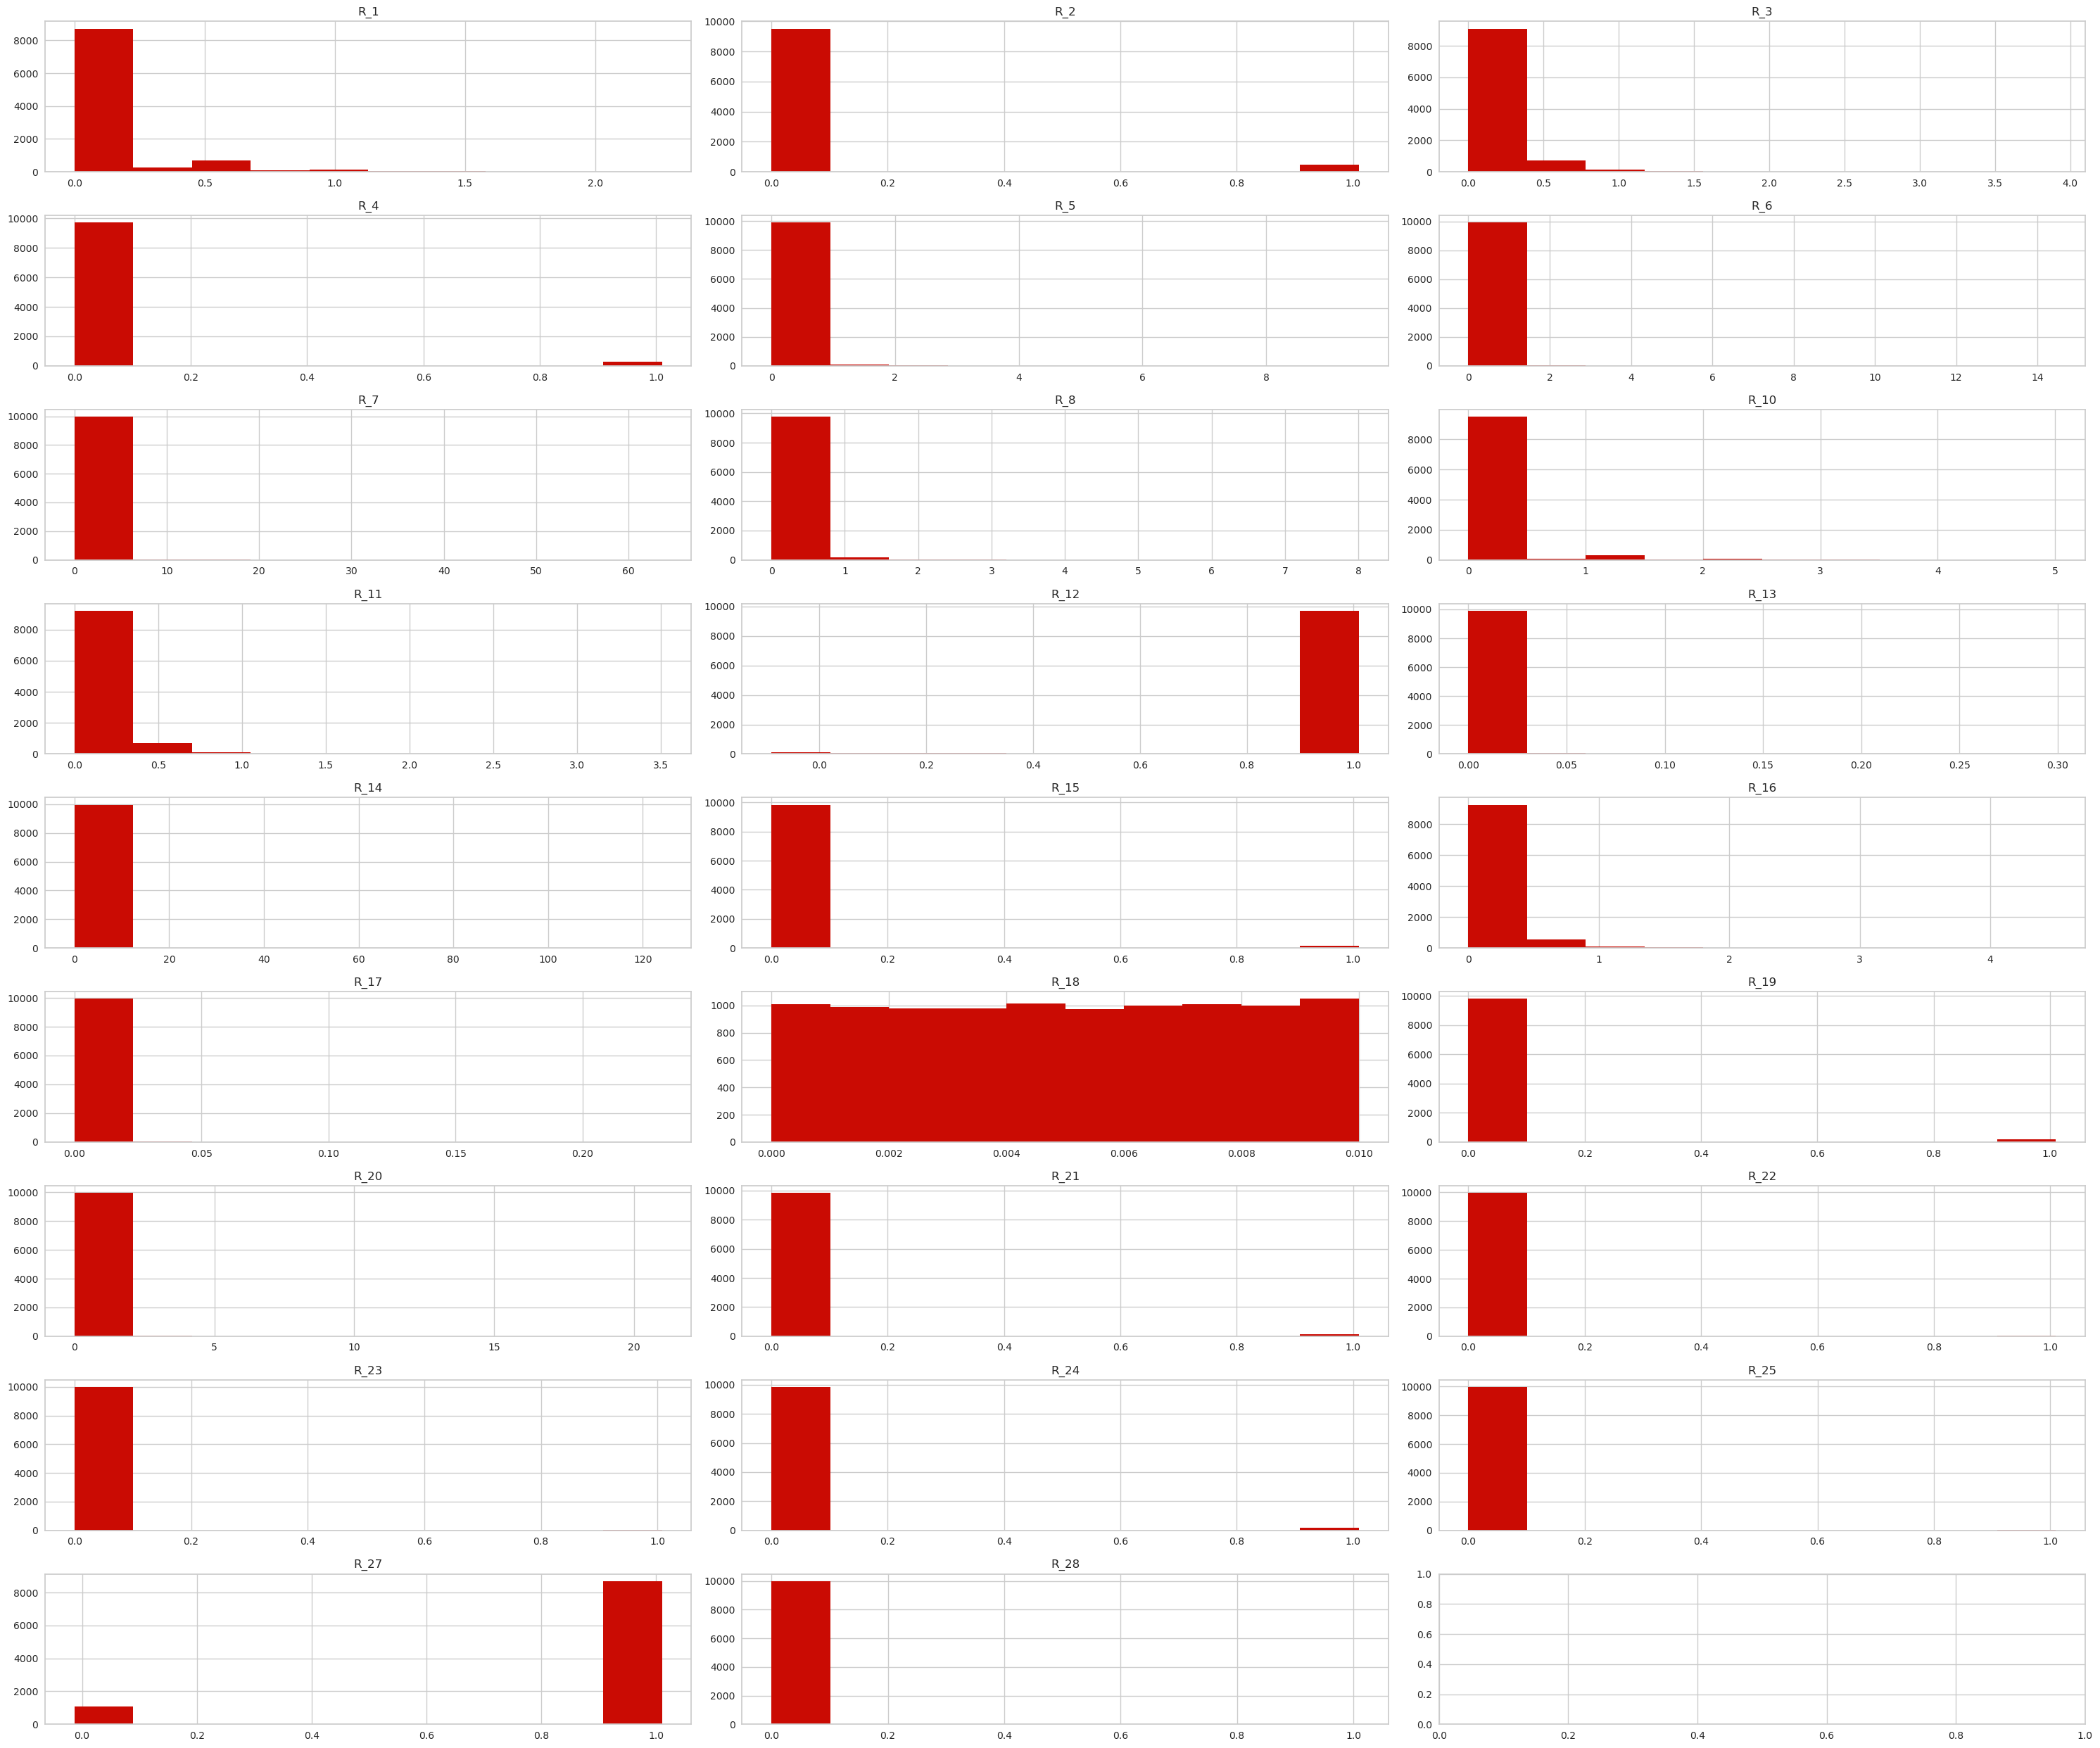

In [61]:
#Plot distribution for R variables
fig, axes = plt.subplots(nrows = 9, ncols = 3, figsize=(30,25)) 
axes = axes.flatten()   
train_df_sample = df_train.sample(frac =.1)
for ax,col in zip(axes,R_columns):
    ax.hist(train_df_sample[col], color="r")
    ax.set_title(col)
    
plt.tight_layout()

## Categorical Variables

Following are categorical variables (As given in Kaggle description):

**['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']**

In [62]:
#List of categorical variables (ones that dont have >=70% NANs)
categ_variables=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

In [63]:
#Display dataframe summary for categorical variables (columns)
df_train[categ_variables].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   B_30    100000 non-null  object
 1   B_38    100000 non-null  object
 2   D_114   100000 non-null  object
 3   D_116   100000 non-null  object
 4   D_117   100000 non-null  object
 5   D_120   100000 non-null  object
 6   D_126   100000 non-null  object
 7   D_63    100000 non-null  object
 8   D_64    95920 non-null   object
 9   D_68    100000 non-null  object
dtypes: object(10)
memory usage: 8.4+ MB


In [64]:
#Display descriptive statistics for categorical variables
df_train[categ_variables].describe(include='all')

B_30    B_38   D_114   D_116   D_117   D_120   D_126    D_63   D_64  \
count   100000  100000  100000  100000  100000  100000  100000  100000  95920   
unique       4       8       3       3       8       3       4       6      4   
top        0.0     2.0     1.0     0.0    -1.0     0.0     1.0      CO      O   
freq     85010   34509   60601   96656   26075   85142   76960   73774  53302   

          D_68  
count   100000  
unique       8  
top        6.0  
freq     50136

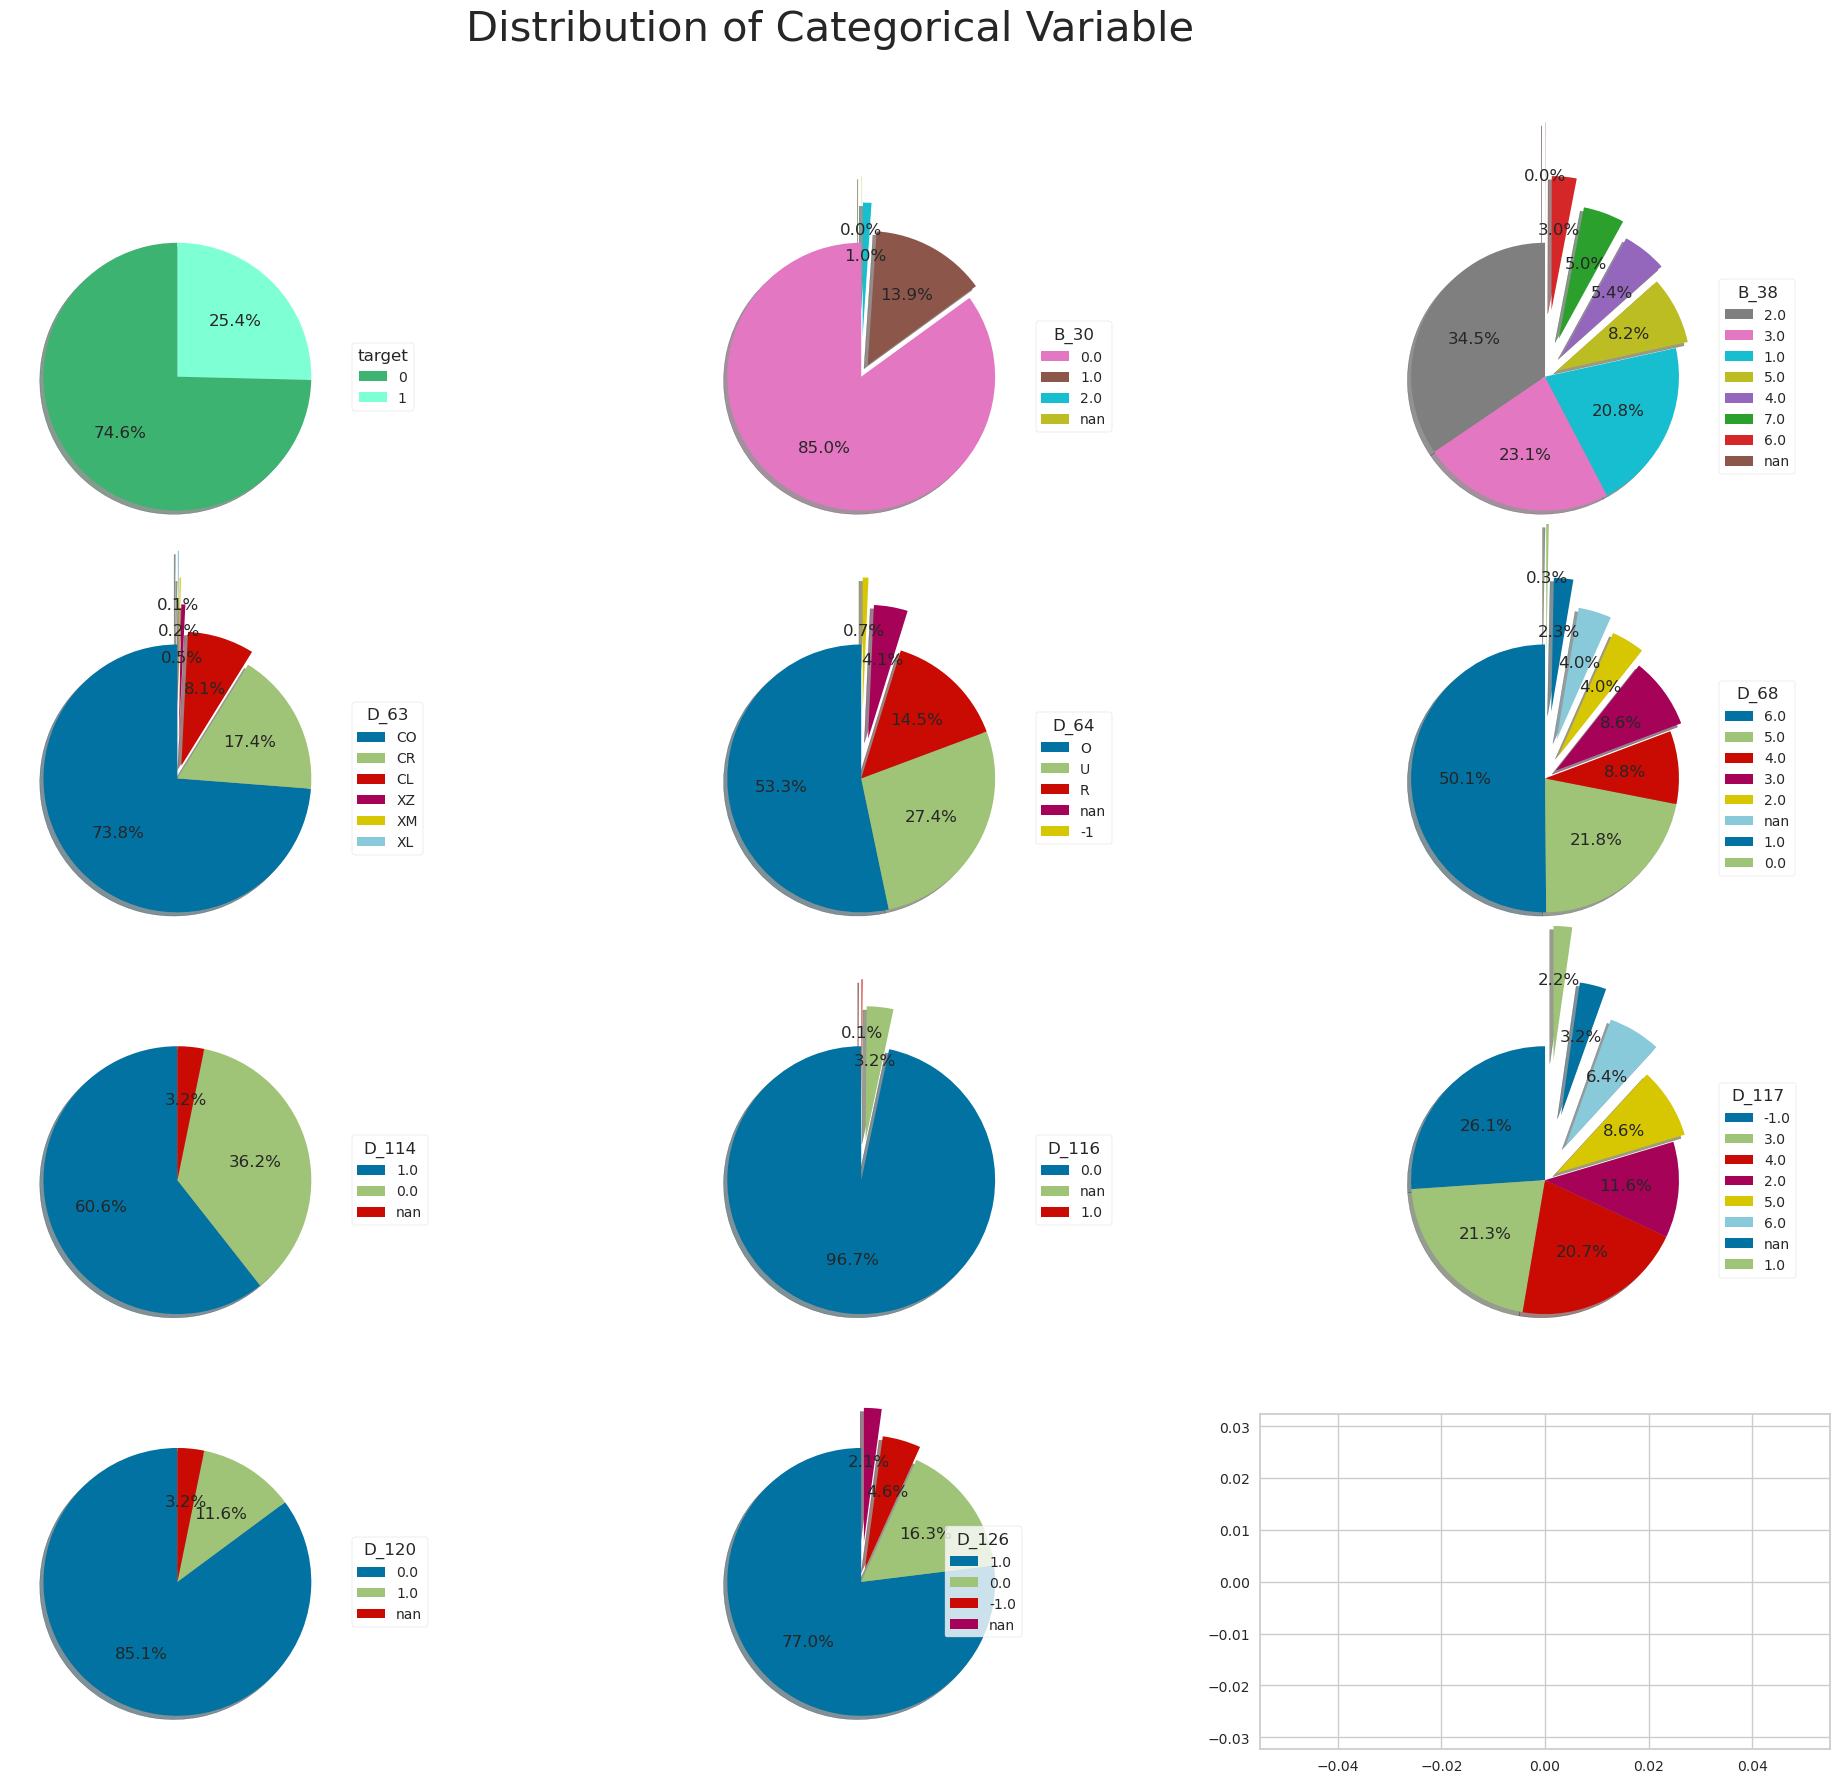

In [65]:
#Plot distribution of categorical variables
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4,3,figsize=(25,20))
fig.suptitle('Distribution of Categorical Variable',fontsize=30)

ax1.pie(df_train['target'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, colors={'aquamarine','mediumseagreen'})
ax1.legend(labels = df_train['target'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='target',frameon = True)

ax2.pie(df_train['B_30'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.1,0.3,0.5), colors={'tab:cyan','tab:olive','tab:pink','tab:brown'})
ax2.legend(labels = df_train['B_30'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_30',frameon = True)

ax3.pie(df_train['B_38'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.1,0.2,0.3,0.5,0.9),colors={'tab:cyan','tab:olive','tab:pink','tab:brown','tab:gray','tab:purple','tab:red','tab:green'})
ax3.legend(labels = df_train['B_38'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='B_38',frameon = True)

ax4.pie(df_train['D_63'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90, explode=(0.0,0.0,0.1,0.3,0.5,0.7))
ax4.legend(labels = df_train['D_63'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5),title ='D_63',frameon = True)

ax5.pie(df_train['D_64'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.3,0.5))
ax5.legend(labels = df_train['D_64'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_64',frameon = True)

ax6.pie(df_train['D_68'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.1,0.2,0.3,0.5,0.9))
ax6.legend(labels = df_train['D_68'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_68',frameon = True)

ax7.pie(df_train['D_114'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax7.legend(labels = df_train['D_114'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_114',frameon = True)

ax8.pie(df_train['D_116'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.3,0.5))
ax8.legend(labels = df_train['D_116'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_116',frameon = True)

ax9.pie(df_train['D_117'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.0,0.0,0.1,0.3,0.5,0.9))
ax9.legend(labels = df_train['D_117'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_117',frameon = True)

ax10.pie(df_train['D_120'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90)
ax10.legend(labels = df_train['D_120'].value_counts(dropna=False).index, loc ='center left', bbox_to_anchor=(1, 0.5), title ='D_120',frameon = True)

ax11.pie(df_train['D_126'].value_counts(dropna=False), autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.0,0.0,0.1,0.3))
ax11.legend(labels = df_train['D_126'].value_counts(dropna=False).index, loc ='center right', title ='D_126',frameon = True)

plt.axis('equal')
fig.show()

# Model Building/Evaluation

In [66]:
#Drop customer ID column from training set
df_train.drop(axis=1, columns=['customer_ID','S_2'], inplace=True)

In [67]:
#Seperating training data into a feature matrtix and target vector
X = df_train.drop(columns='target')
y = df_train['target']

In [68]:
print("Shape of X is:", X.shape)

Shape of X is: (100000, 163)


In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 163 entries, P_2 to D_145
dtypes: float64(152), int64(1), object(10)
memory usage: 125.1+ MB


Observation:
* We see that the feature matrix has 100,000 rows, and 163 features. 152 which are of dtype float64, 1 of dtpe int64, and 10 of dtype object


In [70]:
print("Shape of y is:", y.shape)

Shape of y is: (100000,)


In [71]:
#Define categorical variables (columns)
categorical = list(X.select_dtypes('object').columns)
print(f"Categorical variables (columns) are: {categorical}")

#Define numerical variables (columns)
numerical = list(X.select_dtypes('number').columns)
print(f"Numerical variables (columns) are: {numerical}")

Categorical variables (columns) are: ['D_63', 'D_64', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
Numerical variables (columns) are: ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86', 'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_

In [72]:
#Creating categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('scaler', StandardScaler())
])

print(cat_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('scaler', StandardScaler())])


In [73]:
#Creating numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('scaler', StandardScaler())
])
print(num_pipe)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())])


In [74]:
#Combining both categorical and numerical pipelines for data transformation process using ColumnTransformer class
preprocess = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

print(preprocess)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['D_63', 'D_64', 'D_68', 'B_30', 'B_38',
                                  'D_114', 'D_116', 'D_117', 'D_120',
                                  'D_126']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 

In [75]:
#Splitting training data into training and validation set
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=.25,stratify=y,random_state=42)

In [76]:
print("Shape of X_train:",X_train.shape)

Shape of X_train: (75000, 163)


In [77]:
print("Shape of X_test:",X_test.shape)

Shape of X_test: (25000, 163)


In [78]:
print("Shape of y_train:",y_train.shape)

Shape of y_train: (75000,)


In [79]:
print("Shape of y_test:",y_test.shape)

Shape of y_test: (25000,)


In [80]:
#Metric used for measuring performance of model per competition guidelines
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
    
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()
    
    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [81]:
#Function for display of model training and validation score
def model_score(model_name):
    print("-----------------------------------------------------------------------")
    print("Training and Evaluation using", model_name)
    print("-----------------------------------------------------------------------")
    print("preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling")
    print("preprocess - Numerical: Missing value Impute and Scaling")
    print("-----------------------------------------------------------------------")
    model = pipe.fit(X_train, y_train)  
    print("-----------------------------------------------------------------------")
    print (model)
    print("-----------------------------------------------------------------------")
    print("model training score: %.3f" % pipe.score(X_train, y_train))
    print("model validation score: %.3f" % pipe.score(X_test, y_test))
    print("-----------------------------------------------------------------------")
    print("Amex Evaluation Metric - Training: %.3f"% amex_metric(pd.DataFrame(y_train), pd.DataFrame(pipe.predict(X_train), columns=['prediction'])))
    print("Amex Evaluation Metric - Validation: %.3f"% amex_metric(pd.DataFrame(y_test), pd.DataFrame(pipe.predict(X_test), columns=['prediction'])))
    print("-----------------------------------------------------------------------")
    print("Classification report using", model_name)
    print("-----------------------------------------------------------------------")
    print(classification_report(y_test,model.predict(X_test)))
    y_test_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred)
    auc = round(metrics.roc_auc_score(y_test, y_test_pred), 4)
    plt.plot(fpr,tpr,label="{}, AUC={}".format(model_name,str(auc)))
    plt.legend()

In [82]:
#Function for display of cross validation score
def model_cross_validation_score(model_name):
    print("-----------------------------------------------------------------------")
    print("Training and Evaluation with Cross Validation using",model_name)
    print("-----------------------------------------------------------------------")
    #Defining metrics
    scoring = ['accuracy', 'precision', 'recall','f1','roc_auc']
    #Cross validation technique
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
    #Cross validation returning both training and test score
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=True,return_estimator=True)
    print('Training Score: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f},f1-score: {:.2f}, ROC AUC: {:.2f}'.format(np.mean(scores['train_accuracy']),np.mean(scores['train_precision']), np.mean(scores['train_recall']), np.mean(scores['train_f1']), np.mean(scores['train_roc_auc'])))
    print('Validation Score: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f},f1-score: {:.2f}, ROC AUC: {:.2f}'.format(np.mean(scores['test_accuracy']),np.mean(scores['test_precision']), np.mean(scores['test_recall']), np.mean(scores['test_f1']), np.mean(scores['test_roc_auc'])))
    print("-----------------------------------------------------------------------")

In [83]:
#Function for display of model score via RandomizedSearchCV
def model_random_search_score(model_name):
    print("-----------------------------------------------------------------------")
    print("Training and Evaluation with RandomizedSearchCV using",model_name)
    print("-----------------------------------------------------------------------")
    random_search.fit(X_train,y_train)
    model = random_search.best_estimator_
    score = random_search.best_score_
    print ("Best Estimator for", model_name,"is", model,"with best score as",score)
    print("-----------------------------------------------------------------------")
    print("Amex Evaluation Metric - Training: %.3f"% amex_metric(pd.DataFrame(y_train), pd.DataFrame(model.predict(X_train), columns=['prediction'])))
    print("Amex Evaluation Metric - Validation: %.3f"% amex_metric(pd.DataFrame(y_test), pd.DataFrame(model.predict(X_test), columns=['prediction'])))
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")
    print(classification_report(y_test,model.predict(X_test)))

In [84]:
#Pipeline steps required for model building,training, and evaluation
steps = [
        ('preprocess', preprocess),
        ('over_sampler',SMOTE(random_state = 42)),
        ('under_sampler',RandomUnderSampler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 10, random_state = 42, n_jobs = -1))),
        ('dimension_reduction', PCA(n_components='mle',random_state = 42)),
        ('model_estimator', RandomForestClassifier(random_state = 42))
    ]
pipe = Pipeline(steps, verbose=True)

## Logistic Regression

-----------------------------------------------------------------------
Training and Evaluation using LogisticRegression
-----------------------------------------------------------------------
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.8s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.8s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.3s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.1min
-----------------------------------------------------------------------
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                

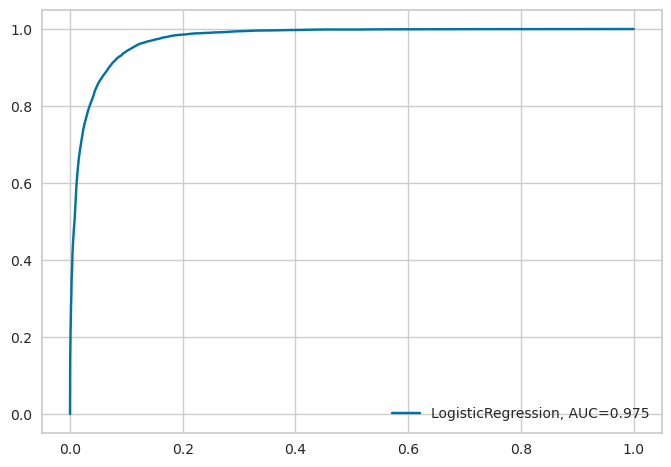

In [85]:
#Using function to display results of model
log_model=model_score("LogisticRegression")

In [86]:
#Using custom function to display cross validation score
model_cross_validation_score("LogisticRegression")

-----------------------------------------------------------------------
Training and Evaluation with Cross Validation using LogisticRegression
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.7s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.3s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.9s
[Pip

## Naive Bayes

-----------------------------------------------------------------------
Training and Evaluation using GaussianNB
-----------------------------------------------------------------------
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.7s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.6s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  10.1s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.3s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.1min
-----------------------------------------------------------------------
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                        

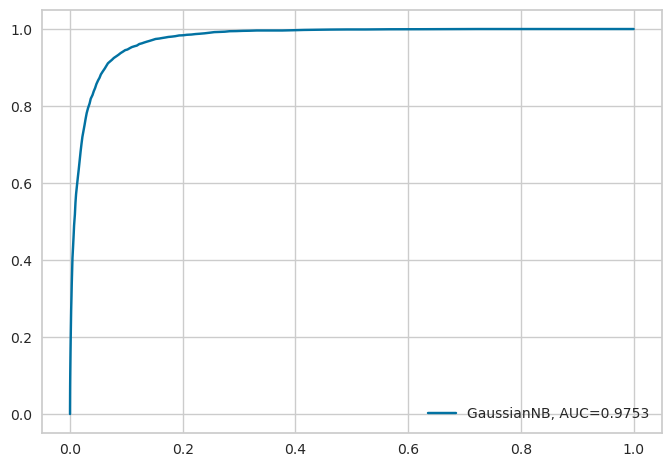

In [87]:
#Using custom function to display results of model
model_score("GaussianNB")

In [88]:
#Using custom function to display cross validation score
model_cross_validation_score("GaussianNB")

-----------------------------------------------------------------------
Training and Evaluation with Cross Validation using GaussianNB
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.3s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.5s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   3.0s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.9s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.9s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.7s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  16.5s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.3s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  17.7s
[Pipeline] .

## KNN

-----------------------------------------------------------------------
Training and Evaluation using KNeighborsClassifier
-----------------------------------------------------------------------
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   9.0s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.5s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.4s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.1min
-----------------------------------------------------------------------
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
              

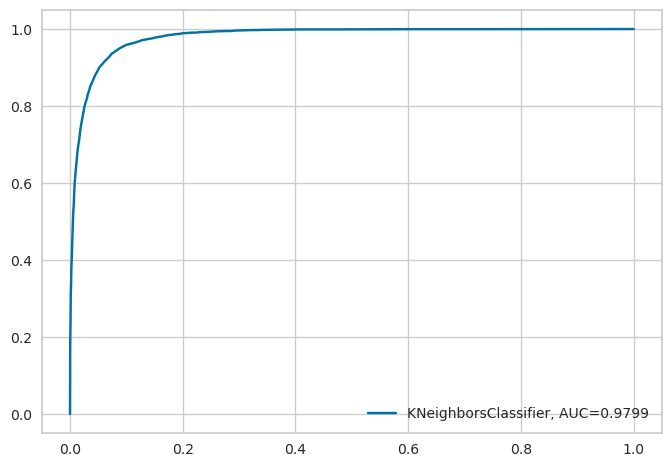

In [89]:
#Using custom function to display results of model
model_score("KNeighborsClassifier")

In [90]:
#Using custom function to display cross validation score
model_cross_validation_score("KNeighborsClassifier")

-----------------------------------------------------------------------
Training and Evaluation with Cross Validation using KNeighborsClassifier
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.3s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.7s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.1s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  16.3s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  17.2s
[P

## Gradient Boosting

-----------------------------------------------------------------------
Training and Evaluation using GradientBoostingClassifier
-----------------------------------------------------------------------
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.7s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=  10.1s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.4s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.1min
-----------------------------------------------------------------------
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
        

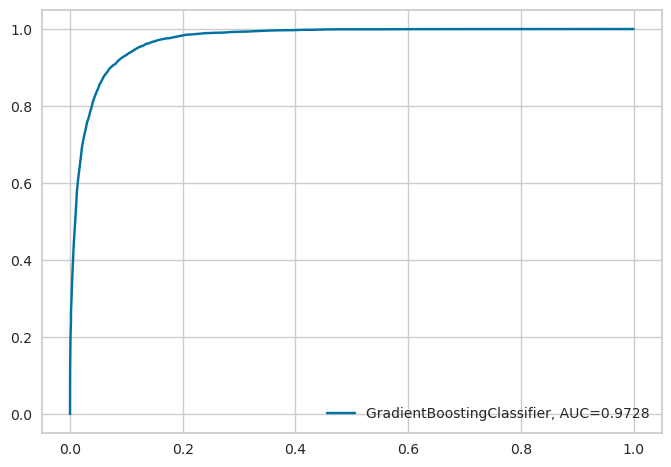

In [91]:
#Using custom function to display results of model
model_score("GradientBoostingClassifier")

In [92]:
#Using custom function to display cross validation score
model_cross_validation_score("GradientBoostingClassifier")

-----------------------------------------------------------------------
Training and Evaluation with Cross Validation using GradientBoostingClassifier
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.3s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.0s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  15.1s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  16.2s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  17

## RandomForest 

-----------------------------------------------------------------------
Training and Evaluation using RandomForestClassifier
-----------------------------------------------------------------------
preprocess - Categorical: Missing value Impute, OneHotEncoding and Scaling
preprocess - Numerical: Missing value Impute and Scaling
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.4s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=   8.6s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] . (step 4 of 6) Processing feature_selection, total=   9.2s
[Pipeline]  (step 5 of 6) Processing dimension_reduction, total=   0.3s
[Pipeline] ... (step 6 of 6) Processing model_estimator, total= 2.0min
-----------------------------------------------------------------------
Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
            

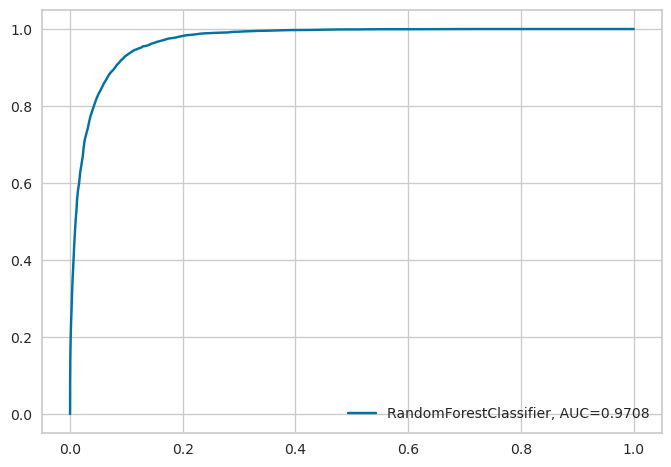

In [93]:
#Using custom function to display results of model
model_score("RandomForestClassifier")

In [94]:
#Using custom function to display cross validation score
model_cross_validation_score("RandomForestClassifier")

-----------------------------------------------------------------------
Training and Evaluation with Cross Validation using RandomForestClassifier
-----------------------------------------------------------------------
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.5s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.6s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ........ (step 1 of 6) Processing preprocess, total=   2.8s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.3s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.1s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  14.4s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  16.3s
[Pipeline] ..... (step 3 of 6) Processing under_sampler, total=   0.2s
[Pipeline] ...... (step 2 of 6) Processing over_sampler, total=  17.0s


## Final Observaion

* The results show that all classifiers performed exceptionally well at predicting whether a cutomer will default.
 It is worth noting that while the AUC/ROC scores provide a good indication of a model's overall performance, it is also important to consider other metrics such as precision, recall, and F1 score, which can provide a more nuanced understanding of a model's strengths and weaknesses. 
 Additionally, it is important to keep in mind that the choice of evaluation metrics should be based on the specific business context and priorities, as different metrics may be more relevant for different applications. 

